<a href="https://colab.research.google.com/github/XateroX/MachineLearning-3DAnderson/blob/devel/WorkOnConv3D_Devel_GColab_AM_Train_3D_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image recognition of Anderson states in 3D

This notebook has four main sections:

*   Preliminaries
  *   Run this at the start to initialize and import many important variables, parameters and libraries. This includes a cell which requires you to authorise the use of a google drive which you will be sent a code to verify the use of.
  *   The google drive must be formatted as follows:
      *   MyDrive
          *    code
          *    csvdata
          *    ModelStages
  *   This format can be tweaked within the code but it ijs likely to cause errors! (see code for more specific guidance on what to call folder and files etc)

*   Functions and main methods
  *    Cells which contain functions that do all kinds of jobs from loading the data in from folders to optimising hyperparameters
*   Result Gathering
  *    Create sub-cells called ***TEST x - description of the test*** then code in a test using the code from the rest of the program. Running only when using the cell to test again ensures that all tests stay in the notebook until it is cleared (as well as many results being saved automatically anyway)
*   Interpretation
    *     Confusion matrix for a given epoch that is saved in the google drive





## Preliminaries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Checking for GPU

In [2]:
#import tensorflow as tf
#from tensorflow.python.client import device_lib

#print(tf.test.gpu_device_name())
#print(device_lib.list_local_devices())

#!cat /proc/meminfo

Checking for TPU

In [3]:
import os
assert os.environ['COLAB_TPU_ADDR']
Path = 'grpc://'+os.environ['COLAB_TPU_ADDR']
print('TPU Address:', Path)

TPU Address: grpc://10.16.203.202:8470


In [4]:
import torch
import torch.nn
torch.__version__
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#!pip install torch=='1.7.0'
#!pip install torchvision=='0.8.1'
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.9.0+cu101
1.8.0+cu101


In [5]:
import random
import math
import pandas as pd

In [6]:
#!pip install fastai==1.0.61
import fastai
from fastai.collab import *
#!pip install --upgrade fastai
#!pip uninstall fastai -y
print(fastai.__version__)
from fastai.vision import *


1.0.61


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###Parameters and variables



In [8]:
global loaded_training
global loaded_validation
global loaded_testing
global loaded_labels
loaded_training   = {}
loaded_validation = {}
loaded_testing    = {}
loaded_labels     = {}

d_type_opt = ('training', 'validation')

bs = 40
epoch_chunk = 3
t_f_default = 0.75
v_f_default = 0.2
global training_fraction
global validation_fraction
training_fraction   = t_f_default
validation_fraction = v_f_default

#Functions and main methods

## Generic Functions


In [9]:
def get_files(folder):
  dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
  N = 1    #Desired number of input systems per class
  files = !ls -l {dir}
  print(files)
  files.reverse()
  files.pop()
  for i in range(len(files)):
    files[i] = files[i].rsplit(' ',1)[1]
    print(files[i])
  return dir,files

In [10]:
def to_list(list):
  py_list = []
  for i in list:
    py_list.append(float(i))
  return py_list

In [11]:
def convert_to_csv(c_array, name):
  headerlist = ["Training Loss","Validation Loss", "Training Accuracy", "Validation Accuracy"]
  c_array = np.array(c_array)
  c_array = np.transpose(c_array)
  c_array_df = pd.DataFrame(c_array)
  c_array_df.to_csv("/content/drive/MyDrive/test_results/"+name+".csv",header=headerlist)

In [12]:
def find_best_lr(learn,start=1e-4,end=5,num_it=100):
  best_ind = -1
  smallest_loss = 100
  for i in range(len(learn.recorder.losses)):
    c_loss = learn.recorder.losses[i]
    if c_loss <= smallest_loss:
      best_ind = i
      smallest_loss = c_loss
  best_lr = learn.recorder.lrs[best_ind]
  return best_lr

Testing concatonating two dataframes to make sure we dont overwrite training data

In [13]:
#headerlist = ["Training Loss","Validation Loss", "Accuracy"]
#c_array = [[1,2,3],[4,5,6],[7,8,9]]
#c_array = np.array(c_array)
#c_array = np.transpose(c_array)
#c_array_df = pd.DataFrame(c_array, columns=headerlist)
#print(c_array_df)
#
#read_array = pd.read_csv("/content/drive/MyDrive/test_results/TEST 9 Results.csv")
#frames = [read_array, c_array_df]
#result = pd.concat(frames)
#print(result)

In [14]:
def make_3D_structure(file, system_size):
    col = 0
    row = 0
    lay = 0
    
    real_3d_with_channel_system = []
    system = []
    for i in range(system_size):
        system.append([])
        for j in range(system_size):
            system[-1].append([])
            for j in range(system_size):
                system[-1][-1].append([])
    #print(len(system))
    #print(len(system[0]))
    #print(len(system[0][0]))
    
    for line in file:
        if col == system_size:
            col = 0
            row += 1
        if row == system_size:
            row = 0
            lay += 1
        system[col][row][lay] = float(line)
        #print(float(line))
        col += 1
    real_3d_with_channel_system.append(system)
    return system#real_3d_with_channel_system

##Object definitions

**Definition of our custom Dataset and label_list class for confusion matrix**

In [15]:
class label_list():
  def __init__(self, data, label_names):
    self.classes = label_names
    self.items = data
  def get(self,i):
    return self.items[i]
  def len(self):
    return len(self.classes)
        

In [16]:
class ThreeDDataset(Dataset):
    def __init__(self, x, y):
        self.x = []
        self.y = []
        class_ind = 0
        for dis_class in x:
          for item in dis_class:
            self.x.append(item)
            self.y.append(class_ind)
          class_ind+=1
        
        def seed():
          return 0.1234

        random.shuffle(self.x, seed)
        random.shuffle(self.y, seed)

        self.y = label_list(self.y, y)
        #print("data: ", len(self.x))
        #print("labels: ", self.y.len(), self.y.items)
        
        self.c = len(self.y.classes)

        t = True
        for dis_class in x:
          t = (t and len(dis_class)==0)
        self.is_empty=t
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i],self.y.get(i)

**Definition of our custom Neural Network Model (not yet in use) **

In [17]:
class NNet(nn.Module):
    def __init__(self, num_classes=17):
        super(NNet, self).__init__()
        self.layers = nn.Sequential(
          nn.Conv2d(20,64,5),
          nn.ReLU(),
          nn.Conv2d(64,64,5),
          nn.ReLU()
        )

    def forward(self, x):
        out = self.layers(x)
        return out
print(NNet)


<class '__main__.NNet'>


In [18]:
def make_custom_network(learn, network_arch):
  def model_append(old_model,layer):
    old_model = nn.Sequential(*list(children(old_model)), layer)
    return old_model

  learn.model = nn.Sequential(*list(children(learn.model)))[:-1]
  learn.model = nn.Sequential(*list(children(learn.model[0])))[:-8]

  for i in range(len(network_arch)):
    learn.model = model_append(learn.model, network_arch[i])

##Load data from folders

In [19]:
import pandas as pd
import io

def prepare_datasets(folder,d_type,seed,size, batch_size=1, binning=False,bin_size=1, skip_amount=0, extr=False, inc_spec_features=[]):

  '''
    This method takes many arguments, including the source directory 'folder' and 
    the type of data 'd_type' (training or validation) and uses it to create a 
    databunch with three datasets: training, validation and testing. It can also
    bin the data, skip classes from the feature set (to simplify training) and you
    can even specify exactly what classes you want ot be in the final feature set.
  '''


  if len(inc_spec_features) != 0: # If we decide to include specific features... 
                                  # ...instead of binning and skipping then... 
                                  # ...stop any other alterations happening
    extr=False
    binning=False
    skip_amount=0


  if extr:
    binning = False
    skip_amount = 0
    
  folder = folder + d_type + '_' + 'seed' + seed
  loaded = False
  class_skipping = (skip_amount>0)

  loaded = False
  if str(folder) in loaded_training.keys():
    print("Found pre-loaded data " + folder)
    tensors_training   = loaded_training[str(folder)]
    tensors_validation = loaded_validation[str(folder)]
    tensors_testing    = loaded_testing[str(folder)]
    labels             = loaded_labels[str(folder)]
    loaded = True

  if not loaded:
    if d_type=='validation':
      training_fraction  =0.1
      validation_fraction=0.99
    elif d_type=='training':
      training_fraction  =t_f_default
      validation_fraction=v_f_default

    dir = '/content/drive/MyDrive/csvdata/'+folder+'/'
    print("   Data directory: ", dir)
    files = !ls -l {dir}
    files.reverse()
    files.pop()
    for i in range(len(files)):
      files[i] = files[i].rsplit(' ',1)[1]
    tensors_training   = []  #Each list in this list is a seperate label list
    tensors_validation = []  #
    tensors_testing    = []  #

    global n_labels
    if len(inc_spec_features) > 0:
      n_labels = len(inc_spec_features)
    else:
      n_labels = len(files)    #Defined by the number of data csv files
      
    print("Number of classes: ", n_labels)

    labels = []
    class_val = 0
    for class_file in files:
      """
      Add new class to the tensors list, read the systems one by one out 
      of the data file then add that data to the correct class list in tensors
      and add the name of the disorder class to the labels list   
      """
      
      if len(inc_spec_features) > 0:      #Dont load classes you dont need
        if (class_val in inc_spec_features) or ((class_val+17) in inc_spec_features) or ((class_val-17) in inc_spec_features):
          print("Included: ", class_file)
          pass
        else:
          print("Skipped: ", class_file)
          class_val+=1
          continue
      else:
        print(class_file)

      if extr:
        print("len files: ", len(files)-1)
        if class_val==0 or class_val==(len(files)-1):
          print("Included: ", class_file)
          pass
        else:
          print("Skipped: ", class_file)
          class_val+=1
          continue
      

      tensors_training.append([])
      tensors_validation.append([])
      tensors_testing.append([])
      disorder_class = class_file.rsplit('-',1)[0]
      disorder_class = disorder_class.rsplit('W',1)[1]
      labels.append(disorder_class)

      with open(dir+class_file, 'r') as f:
        df = pd.read_csv(f)
        print("Actual file directory: ", dir+class_file)

      for i in range(len(df.transpose())-1):         
        """
        Go through each system and add them to the data
        """           
        ThreeD_array = make_3D_structure(to_list(df[str(i)]),size)
        system = torch.tensor(ThreeD_array)

        ran_numb = random.random()
        if ran_numb >= 1 - training_fraction:
          tensors_training[-1].append(system)
        
        elif ran_numb < validation_fraction:
          tensors_validation[-1].append(system)
        
        else:
          tensors_testing[-1].append(system)
      class_val+=1
    #print(labels)

    if str(folder) not in loaded_training.keys() and len(inc_spec_features)==0:   #Saving the models in a global dictionary for faster loading later
      print("No pre-existing data " + folder + ". Saving in dictionary")
      loaded_training[str(folder)]   = tensors_training
      loaded_validation[str(folder)] = tensors_validation
      loaded_testing[str(folder)]    = tensors_testing
      loaded_labels[str(folder)]     = labels


    
  if class_skipping:    #Skipping every 'skip_amount' classes
    new_labels = []
    for i in range(len(labels)):
      if i*(skip_amount+1) > len(labels)-1:
        break
      new_labels.append(labels[i*(skip_amount+1)])
    labels = new_labels
    print("After skipping: ", labels)

    new_tensors_training = []
    for i in range(len(tensors_training)):
      if i*(skip_amount+1) > len(tensors_training)-1:
        break
      new_tensors_training.append(tensors_training[i*(skip_amount+1)])
    tensors_training = new_tensors_training

    new_tensors_validation = []
    for i in range(len(tensors_validation)):
      if i*(skip_amount+1) > len(tensors_validation)-1:
        break
      new_tensors_validation.append(tensors_validation[i*(skip_amount+1)])
    tensors_validation = new_tensors_validation

    new_tensors_testing = []
    for i in range(len(tensors_testing)):
      if i*(skip_amount+1) > len(tensors_testing)-1:
        break
      new_tensors_testing.append(tensors_testing[i*(skip_amount+1)])
    tensors_testing = new_tensors_testing

    print("")
    print("")
    print("")
    print("----")
    print("   Including only every " + str(skip_amount) + " classes")
    print("len labels:     ", len(labels))
    print("len training:   ", len(tensors_training))
    print("len validation: ", len(tensors_validation))
    print("len testing:    ", len(tensors_testing))
    print("labels =        ", labels)
    print("----")
    print("")
    print("")
    print("")

  if binning:        #Bin each of the datasets
    print("")
    print("")
    print("")
    print("----")
    print("   Binning data")
    binned_labels = []
    binned_tensors_training = []
    binned_tensors_validation = []
    binned_tensors_testing = []

    binned_labels.append([])   
    binned_tensors_training.append([])
    binned_tensors_validation.append([])
    binned_tensors_testing.append([])

    print(len(labels)) 
    for i in range(len(labels)):       
      for label in labels[i]:
        binned_labels[-1].append(label)
      if (i+1)%bin_size == 0:
        binned_labels.append([])
    if len(labels)%bin_size != 0:
      del binned_labels[-1]
    print("total bins (la): ", len(binned_labels))
    labels = binned_labels
    n_labels = len(labels)
    print(len(labels))

    print(len(tensors_training)) 
    for i in range(len(tensors_training)):       
      for tensor in tensors_training[i]:
        binned_tensors_training[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_training.append([])
    if len(tensors_training)%bin_size != 0:
      del binned_tensors_training[-1]
    print("total bins (tr): ", len(binned_tensors_training))
    tensors_training = binned_tensors_training

    print(len(tensors_validation))
    for i in range(len(tensors_validation)):
      for tensor in tensors_validation[i]:
        binned_tensors_validation[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_validation.append([])
    if len(tensors_validation)%bin_size != 0:
      del binned_tensors_validation[-1]
    print("total bins (va): ", len(binned_tensors_validation))
    tensors_validation = binned_tensors_validation

    print(len(tensors_testing))
    for i in range(len(tensors_testing)):
      for tensor in tensors_testing[i]:
        binned_tensors_testing[-1].append(tensor)
      if (i+1)%bin_size == 0:
        binned_tensors_testing.append([])
    if len(tensors_testing)%bin_size != 0:
      del binned_tensors_testing[-1]
    print("total bins (te): ", len(binned_tensors_testing))
    tensors_testing = binned_tensors_testing
    print("----")
    print("")
    print("")
    print("")



  
  if extr:   #Take only the most extreme classes from the data
    t_labels = []
    t_labels.append(labels[0])
    t_labels.append(labels[-1])
    labels = t_labels
    n_labels = len(labels)

    t_tensors_training = []
    t_tensors_training.append(tensors_training[0])
    t_tensors_training.append(tensors_training[-1])
    tensors_training = t_tensors_training

    t_tensors_validation = []
    t_tensors_validation.append(tensors_validation[0])
    t_tensors_validation.append(tensors_validation[-1])
    tensors_validation = t_tensors_validation

    t_tensors_testing = []
    t_tensors_testing.append(tensors_testing[0])
    t_tensors_testing.append(tensors_testing[-1])
    tensors_testing = t_tensors_testing

    print("")
    print("")
    print("")
    print("----")
    print("   Taking only the extreme classes")
    print("len labels:     ", len(labels))
    print("len training:   ", len(tensors_training))
    print("len validation: ", len(tensors_validation))
    print("len testing:    ", len(tensors_testing))
    print("labels =        ", labels)
    print("----")
    print("")
    print("")
    print("")
  
  #if len(inc_spec_features) > 0:
    #labels=[labels[x] for x in inc_spec_features]
    #n_labels = len(labels)
    #tensors_training=[tensors_training[x] for x in inc_spec_features]
    #tensors_validation=[tensors_validation[x] for x in inc_spec_features]
    #tensors_testing=[tensors_testing[x] for x in inc_spec_features]
    #print("")
    #print("")
    #print("")
    #print("----")
    #print("   Taking only specific classes")
    #print("len labels:     ", len(labels))
    #print("len training:   ", len(tensors_training))
    #print("len validation: ", len(tensors_validation))
    #print("len testing:    ", len(tensors_testing))
    #print("labels =        ", labels)
    #print("----")
    #print("")
    #print("")
    #print("")
  

  print("")
  print("")
  print("---------")
  print("   Length of training set: ", len(tensors_training))
  print("   Length of validation set: ", len(tensors_validation))
  print("   Length of testing set: ", len(tensors_testing))
  print("---------")
  print("")
  print("")
  loader_training = ThreeDDataset(tensors_training, labels)
  loader_validation = ThreeDDataset(tensors_validation, labels)
  loader_testing = ThreeDDataset(tensors_testing, labels)
  databunch = DataBunch.create(loader_training, loader_validation, loader_testing, bs=batch_size, num_workers=0)

  return databunch

##Create CnnLearner

In [20]:
def create_learner(folder,d_type,seed,size=20, show_model=False, batch_size=1, binning=False,bin_size=1, skip_amount=0, opt=optim.Adam, save=True, extr=False, model=models.resnet18, model_str='resnet18', arch=[], inc_spec_features=[]):
  global learn_sys_size
  learn_sys_size=size
  if size!=20:
    folder = str(folder + str(size) + '_')
  print('folder for prep_data: ', folder)
  databunch = prepare_datasets(str('raw_data_' + str(size) + '/' + folder), d_type, seed, size, binning=binning, batch_size=batch_size, bin_size=bin_size, skip_amount=skip_amount, extr=extr, inc_spec_features=inc_spec_features)
  global learn 
  learn = cnn_learner(databunch, model, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=opt, pretrained=False)

  batch_size = learn.data.batch_size
  global c_model
  global classes_val
  c_model = str(model_str)         #Model
  if len(inc_spec_features) > 0:
    classes = "classes="+str(len(inc_spec_features))+"-"
    classes_val = len(inc_spec_features) 
  if extr:
    classes = "classes="+str(2)+"-"
    classes_val = 2
  if len(inc_spec_features) <= 0 and not extr:
    classes = "classes="+str(17)+"-"
    classes_val = 17
  metric = '-metric=error_rate-'   #Metric
  loss = 'loss=CrossEntropyLoss-'  #Loss 
  optimizer = 'opt=ADAM-'
  twod_or_threed = 'CONV2D-'
  batch_size = 'bs='+str(batch_size)
  ntrain = '-ntrain='+folder+d_type+'_'+seed
  c_model = classes + twod_or_threed + c_model + metric + loss + optimizer + batch_size + ntrain

  if len(arch)!=0:
    print("")
    print("")
    print("#!! CHANGING THE NETWORK TO CUSTOM !!#")
    print("")
    print("")
    make_custom_network(learn, arch)
  else:
    learn.model[0][0] = nn.Conv2d(size, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)
  
  if save:
    print('Saving the model as: ', '/content/drive/MyDrive/ModelStages/' + str(learn_sys_size) + '/' + str(classes_val) + '/' + c_model)
    !mkdir /content/drive/MyDrive/ModelStages/{str(size)}
    #!mkdir /content/drive/MyDrive/ModelStages/{str(size)}/{c_model}
    !mkdir /content/drive/MyDrive/ModelStages/{str(size)}/{str(classes_val)}
    !mkdir /content/drive/MyDrive/ModelStages/{str(size)}/{str(classes_val)}/{c_model}
    learn.save('/content/drive/MyDrive/ModelStages/' + str(learn_sys_size) + '/' + str(classes_val) + '/' + c_model + '/epochs-0')

  #nn.Sequential.children.append()
  
  
  print("Model len: ", len(learn.model))

  for layer in learn.model:
    print("Layer:     ", layer)

  if show_model:
    print(learn.summary())

  if d_type=='training' and save:
    learn.lr_find(start_lr=1e-4, end_lr=5, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

    best_ind = -1
    smallest_loss = 100
    for i in range(len(learn.recorder.losses)):
      c_loss = learn.recorder.losses[i]
      if c_loss <= smallest_loss:
        best_ind = i
        smallest_loss = c_loss
    best_lr = learn.recorder.lrs[best_ind]
    global best_learner_lr
    best_learner_lr = best_lr
    print("Best lr for this learner is: ", best_learner_lr)

##Create Custom Learner

In [21]:
def create_custom_learner(folder,d_type,seed, show_model=False, batch_size=1, binning=False,bin_size=1, skip_amount=0, opt=optim.Adam, save=True):
  databunch = prepare_datasets(folder, d_type, seed, binning=binning, batch_size=batch_size, bin_size=bin_size, skip_amount=skip_amount)
  global learn 
  learn = Learner(databunch, NNet, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=opt, pretrained=False)
  global c_model
  c_model = 'densenet121-'      #Model
  metric = 'metric=error_rate-'     #Metric
  loss = 'loss=CrossEntropyLoss-' #Loss 
  optimizer = 'opt=ADAM-'
  twod_or_threed = 'CONV2D-'
  c_model = twod_or_threed+c_model+metric+loss+optimizer

  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)
  
  if show_model:
    learn.summary()

  if d_type=='training' and save:
    learn.lr_find(start_lr=1e-4, end_lr=5, num_it=100, stop_div=False)
    learn.recorder.plot()
    learn.recorder.plot_lr()

  if save:
    c_model_t = c_model +'bs='+str(learn.recorder.train_dl.batch_size)+'-ntrain='+folder+d_type+'_'+seed#str(learn.recorder.train_dl.dl.dataset.__len__())
    !mkdir /content/drive/MyDrive/ModelStages/{c_model_t}
    learn.save('/content/drive/MyDrive/ModelStages/'
                                +c_model
                                +'bs='+str(learn.recorder.train_dl.batch_size)
                                +'-ntrain='+folder+d_type+'_'+seed #str(learn.recorder.train_dl.dl.dataset.__len__())
                                +'/epochs-0')

##Baysian Optimisation functions


In [22]:
def fit_with(lr, mom, wd):

  '''
  You can define your own fit_with() function that takes in the arguments you give to the 
  pbounds object (a dictionary whose keys are the names of the parameters and
  whose items are tuples containing the bounds for each parameter)
   and uses them to calculate an 'accuracy' that you then return.
  optimise_bayesian() then uses this function as a metric to give the optimal 
  values of the parameters you enter (in the ranges you specify in pbounds)
  '''

  folder = 'raw_data_transfering_200_'
  d_type = d_type_opt[0]
  seed = str(1111)
  batch_size = 120
  databunch = prepare_datasets(folder, d_type, seed, batch_size=batch_size, binning=True, bin_size=3, skip_amount=0)

  learn = cnn_learner(databunch, models.densenet121, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=optim.SGD, pretrained=False)
  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  learn.fit_one_cycle(1, max_lr=lr)
  learn.recorder.plot_losses()
  acc = float(learn.validate(learn.data.valid_dl)[1])

  print("Accuracy:" + str(acc*100))
  return acc

In [23]:
def optimise_bayesian(pbounds,fit_with):
  !pip install bayesian-optimization
  from bayes_opt import BayesianOptimization

  #pbounds = {'lr': (1e-3, 1e+1), 'mom':(0, 0.99), 'wd':(1e-4, 1)}

  optimizer = BayesianOptimization(
      f=fit_with,
      pbounds=pbounds,
      verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
      random_state=1,
  )   

  optimizer.maximize(init_points=2, n_iter=5)

  for i, res in enumerate(optimizer.res):
      print("Iteration {}: \n\t{}".format(i, res))

  print(optimizer.max)
  return optimizer.max

##Training Functions


In [24]:
def train_max_epochs(epoch_goal, lr=-1,lr_max=1,lr_min=0.01, mom=0, weight_decay=0, epoch_chunk=5, save=True,save_csv=True, csv_name="TEST", load=False, folder=''):
  folder = folder+str(learn_sys_size)+'_'
  if lr=='BEST':
    lr = best_learner_lr #find_best_lr(learn, 1e-4,5)

  n_epochs_total = 0
  #learn.unfreeze()
  validation_accuracy = []
  validation_losses   = []
  training_accuracy   = []
  training_losses     = []

  n_batches = len(learn.recorder.train_dl)
  print("Number of batches = ", n_batches)
  if not load:
    #epoch_chunk = epoch_goal
    print("no load - epoch chunk = ", epoch_chunk)
  while n_epochs_total < epoch_goal:
    if load:
      folder = '/content/drive/MyDrive/ModelStages/'+str(learn_sys_size)+'/'+ str(classes_val) +'/'+c_model
      n_epochs_total = load_latest_training(learn, folder)
      print("Best training so far: ", n_epochs_total)

    print("Using (max) lr of: ", lr)
    print("lr being used: ", slice(1e-6,1e-4))
    learn.fit_one_cycle(epoch_chunk,max_lr=slice(1e-6,1e-4),moms=mom,wd=weight_decay)
    #learn.fit_one_cycle(epoch_chunk,max_lr=slice(1e-5,lr),moms=mom,wd=weight_decay)
    n_epochs_total += epoch_chunk

    print('/content/drive/MyDrive/ModelStages/'+str(learn_sys_size)+'/'+ str(classes_val) +'/'
      +c_model
      +'/epochs-'+str(n_epochs_total)
      +'-max_lr='+str(lr)
      +'-mom='+str(mom))

    if save:
      print('Saving epoch chunk as: ', '/content/drive/MyDrive/ModelStages/'+str(learn_sys_size)+'/'+ str(classes_val) +'/'
      +c_model
      +'/epochs-'+str(n_epochs_total)
      +'-max_lr='+str(lr)
      +'-mom='+str(mom))

      learn.save('/content/drive/MyDrive/ModelStages/'+str(learn_sys_size)+'/'+ str(classes_val) +'/'
      +c_model
      +'/epochs-'+str(n_epochs_total)
      +'-max_lr='+str(lr)
      +'-mom='+str(mom))
      
    print("Result of validate (train): ", learn.validate(learn.data.train_dl))
    print("Result of validate (valid): ", learn.validate(learn.data.valid_dl))
    train_acc = float(learn.validate(learn.data.train_dl)[1])
    print("train_acc = ", train_acc)
    valid_acc = float(learn.validate(learn.data.valid_dl)[1])
    print("valid_acc = ", valid_acc)
    for i in range(epoch_chunk):
      validation_accuracy.append(valid_acc)
      training_accuracy.append(train_acc)
    for c_val_loss in learn.recorder.val_losses:
      validation_losses.append(c_val_loss)
    for i in range(1,epoch_chunk+1):
      training_losses.append(learn.recorder.losses[i*n_batches-1].item())
    print("losses: ", training_losses)
    print("validation_losses: ", validation_losses)

    if save_csv:
      convert_to_csv([training_losses, validation_losses, training_accuracy, validation_accuracy], csv_name)
  learn.recorder.plot_metrics()
  learn.recorder.plot_losses()
  return training_losses, validation_losses, accuracy

In [25]:
def train_with_parameters(epochs_max,epoch_chunk=10, batch_size=30, opt=optim.Adam, mom=0, weight_decay=0, lr=0.1):
  folder = 'raw_data_transfering_4000_'
  d_type = d_type_opt[0]
  seed=str(1111)

  create_learner(folder,d_type,seed, batch_size=batch_size, binning=False,bin_size=1, skip_amount=0, opt=opt, save=True)
  training_losses,validation_losses = train_max_epochs(epochs_max,lr,mom,weight_decay, epoch_chunk,save=False)
  return training_losses,validation_losses

In [26]:
def load_latest_training(learn, folder):
  training_files = !ls -l {folder}
  training_files.reverse()
  training_files.pop()

  for i in range(len(training_files)):
      training_files[i] = training_files[i].rsplit(' ',1)[1]
      training_files[i] = training_files[i].rsplit('.',1)[0]

  max_epoch_value = 0
  max_epoch_ind = -1
  if len(training_files)!=1:
    for i in range(len(training_files)-1):
      training_files[i] = training_files[i].rsplit('\'',1)[1]
      if int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0]) > max_epoch_value:
        max_epoch_value = int(training_files[i].rsplit('-',-1)[1].rsplit('-',-1)[0])
        max_epoch_ind = i
  else:
    max_epoch_ind = 0
  print("loading epoch ", folder+'/'+str(training_files[max_epoch_ind]))
  learn.load(folder+'/'+str(training_files[max_epoch_ind]))
  learn.unfreeze()
  
  
  return max_epoch_value

#Result Gathering

###Local Tests

In [ ]:
local_tests = {}

####TEST Simple - Run this cell to train a network on some simple data

In [ ]:
    #TEST Simple - Run this cell to train a network on some simple data
folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True)

Found pre-loaded data raw_data_20/raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----



Model len:  2
Layer:      Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
Layer:      Linear(in_features=64, out_features=2, bias=False)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

In [ ]:
local_tests["TEST Simple"] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

RuntimeError: ignored

####TEST 1 - Densenet121 4000 systems def hyperparameters (Extremised)

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_transfering_4000_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
W16.8-4000data_seed1111.csv
W16.7-4000data_seed1111.csv
W16.6-4000data_seed1111.csv
W16.5-4000data_seed1111.csv
W16.4-4000data_seed1111.csv
W16.3-4000data_seed1111.csv
W16.2-4000data_seed1111.csv
W16.0-4000data_seed1111.csv
W15.75-4000data_seed1111.csv
W15.5-4000data_seed1111.csv
W15.25-4000data_seed1111.csv
W15.0-4000data_seed1111.csv
No pre-existing data raw_data_transfering_4000_training_seed1111. Saving in dictionary
['18.0', '17.75', '17.5', '17.25', '17.0', '16.8', '16.7', '16.6', '16.5', '16.4', '16.3', '16.2', '16.0', '15.75', '15.5', '15.25', '15.0']



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,2.825130,2.519966,0.352866,00:59
1,2.441033,2.205426,0.553503,00:59
2,2.216763,1.990909,0.637580,01:00
3,2.058016,1.859247,0.680255,00:59
4,1.931634,1.791680,0.703185,00:59
5,1.823080,1.737212,0.733121,00:59
6,1.817830,1.700183,0.750318,00:59
7,1.720053,1.658275,0.761146,01:00
8,1.704483,1.626734,0.766879,00:59
9,1.650427,1.606878,0.776433,01:08


epoch,train_loss,valid_loss,accuracy,time
0,2.825130,2.519966,0.352866,00:59
1,2.441033,2.205426,0.553503,00:59
2,2.216763,1.990909,0.637580,01:00
3,2.058016,1.859247,0.680255,00:59
4,1.931634,1.791680,0.703185,00:59
5,1.823080,1.737212,0.733121,00:59
6,1.817830,1.700183,0.750318,00:59
7,1.720053,1.658275,0.761146,01:00
8,1.704483,1.626734,0.766879,00:59
9,1.650427,1.606878,0.776433,01:08


/content/drive/MyDrive/ModelStages/CONV2D-densenet121-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_training/epochs-100-max_lr=1-mom=0
losses:  [2.825129508972168, 2.441033124923706, 2.2167630195617676, 2.058015823364258, 1.931633710861206, 1.8230799436569214, 1.8178304433822632, 1.7200530767440796, 1.704483151435852, 1.6504273414611816, 1.5839580297470093, 1.5605323314666748, 1.5180165767669678, 1.5062955617904663, 1.4600483179092407, 1.4190311431884766, 1.3607779741287231, 1.3526841402053833, 1.2477176189422607, 1.2225147485733032, 1.203763723373413, 1.1735872030258179, 1.1619558334350586, 1.0993340015411377, 1.078810214996338, 1.026023268699646, 0.9981096386909485, 0.9434571266174316, 0.9051278233528137, 0.8587629199028015, 0.7960193753242493, 0.7683948278427124, 0.7732759118080139, 0.7269304394721985, 0.7135729789733887, 0.6773287653923035, 0.6431821584701538, 0.6127822995185852, 0.5946587324142456, 0.5605877041816711, 0.5348622798919678, 0

([2.825129508972168,
  2.441033124923706,
  2.2167630195617676,
  2.058015823364258,
  1.931633710861206,
  1.8230799436569214,
  1.8178304433822632,
  1.7200530767440796,
  1.704483151435852,
  1.6504273414611816,
  1.5839580297470093,
  1.5605323314666748,
  1.5180165767669678,
  1.5062955617904663,
  1.4600483179092407,
  1.4190311431884766,
  1.3607779741287231,
  1.3526841402053833,
  1.2477176189422607,
  1.2225147485733032,
  1.203763723373413,
  1.1735872030258179,
  1.1619558334350586,
  1.0993340015411377,
  1.078810214996338,
  1.026023268699646,
  0.9981096386909485,
  0.9434571266174316,
  0.9051278233528137,
  0.8587629199028015,
  0.7960193753242493,
  0.7683948278427124,
  0.7732759118080139,
  0.7269304394721985,
  0.7135729789733887,
  0.6773287653923035,
  0.6431821584701538,
  0.6127822995185852,
  0.5946587324142456,
  0.5605877041816711,
  0.5348622798919678,
  0.5138978362083435,
  0.49755752086639404,
  0.4757506251335144,
  0.4685657322406769,
  0.4690560996532

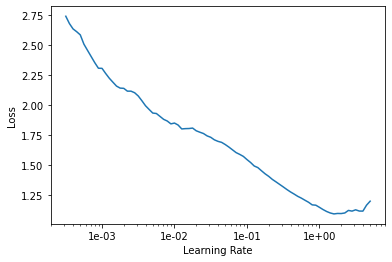

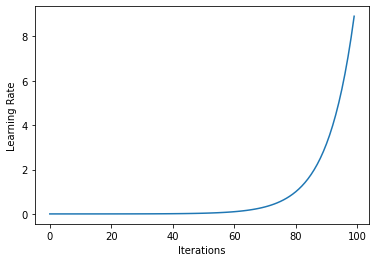

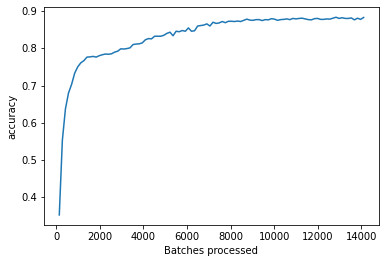

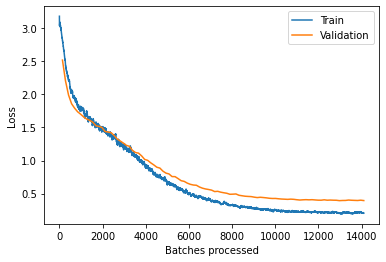

In [ ]:
    #TEST 1 - Densenet121 4000 systems def hyperparameters
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True)

In [ ]:
local_tests["TEST 1"] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

####TEST 2 - Resnet18 4000 systems def hyperparameters (Extremesized)

Found pre-loaded data raw_data_20/raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----



Model len:  2
Layer:      Sequential(
  (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_200_training_1111’: File exists


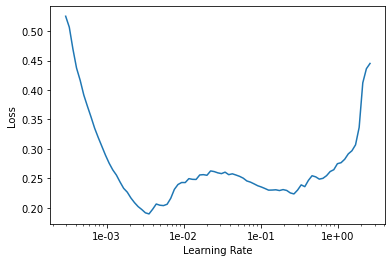

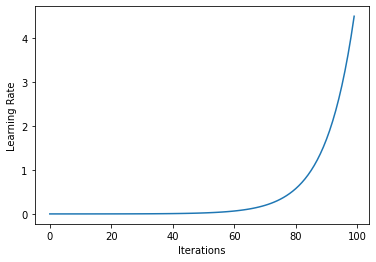

In [ ]:
    #TEST 2 - Resnet18 4000 systems def hyperparameters
folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True, batch_size=120)

In [ ]:
local_tests["TEST 2"] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,0.851135,0.701091,0.469388,00:05
1,0.845597,0.696198,0.469388,00:05
2,0.844770,0.693095,0.540816,00:05
3,0.851917,0.692596,0.530612,00:05
4,0.855222,0.696807,0.520408,00:05
5,0.839985,0.702490,0.418367,00:05
6,0.832117,0.709356,0.428571,00:05
7,0.819009,0.721002,0.469388,00:05
8,0.803708,0.744323,0.459184,00:05
9,0.775250,0.795864,0.469388,00:05


KeyboardInterrupt: ignored

####TEST 3 - Densenet121 4000 systems optimised hyperparameters (Bayesian)

|   iter    |  target   |    lr     |    mom    |    wd     |
-------------------------------------------------------------
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.789736,1.442247,0.444444,00:03


Accuracy:44.44444477558136
|  1        |  0.4444   |  4.176    |  0.7131   |  0.000214 |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.757250,1.072803,0.444444,00:03


Accuracy:44.44444477558136
|  2        |  0.4444   |  3.03     |  0.1453   |  0.09243  |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.443812,1.307428,0.444444,00:03


Accuracy:44.44444477558136
|  3        |  0.4444   |  9.995    |  0.603    |  0.9639   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,2.823051,2.797831,0.444444,00:03


Accuracy:44.44444477558136
|  4        |  0.4444   |  0.02403  |  0.03857  |  0.1931   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.512010,1.125738,0.444444,00:03


Accuracy:44.44444477558136
|  5        |  0.4444   |  9.996    |  0.9884   |  0.9916   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,2.772453,2.814824,0.222222,00:03


Accuracy:22.22222238779068
|  6        |  0.2222   |  0.0189   |  0.08859  |  0.5048   |
Found pre-loaded data raw_data_transfering_200_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





epoch,train_loss,valid_loss,accuracy,time
0,1.573440,1.092884,0.444444,00:03


Accuracy:44.44444477558136
|  7        |  0.4444   |  7.267    |  0.0      |  0.0001   |
Iteration 0: 
	{'target': 0.4444444477558136, 'params': {'lr': 4.176049826978714, 'mom': 0.7131212485077365, 'wd': 0.00021436337986315216}}
Iteration 1: 
	{'target': 0.4444444477558136, 'params': {'lr': 3.0303024005920793, 'mom': 0.14528833190894191, 'wd': 0.09242936090932093}}
Iteration 2: 
	{'target': 0.4444444477558136, 'params': {'lr': 9.994907470166536, 'mom': 0.6030195403462183, 'wd': 0.9639363225833915}}
Iteration 3: 
	{'target': 0.4444444477558136, 'params': {'lr': 0.024025680336417, 'mom': 0.038569443073310644, 'wd': 0.19309903551955998}}
Iteration 4: 
	{'target': 0.4444444477558136, 'params': {'lr': 9.996347945075506, 'mom': 0.9884278864960957, 'wd': 0.9915658322715345}}
Iteration 5: 
	{'target': 0.2222222238779068, 'params': {'lr': 0.018902601788937698, 'mom': 0.08859200705091115, 'wd': 0.5047570054903805}}
Iteration 6: 
	{'target': 0.4444444477558136, 'params': {'lr': 7.267408290812069,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_200_training_1111’: File exists


NameError: ignored

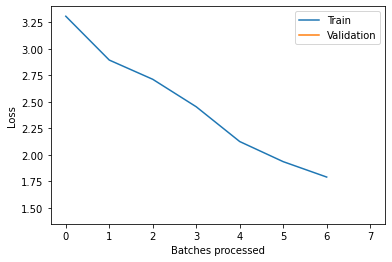

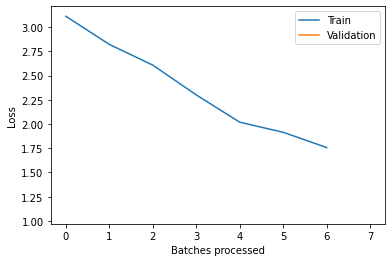

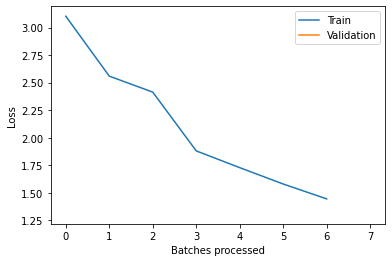

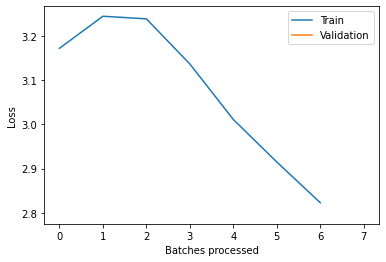

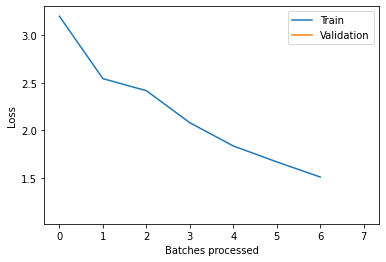

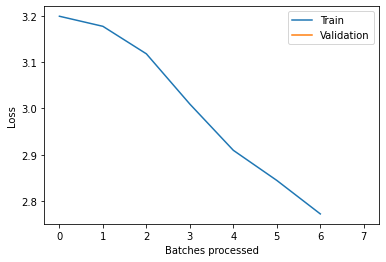

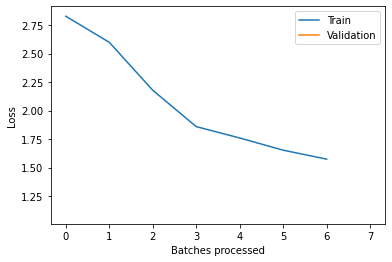

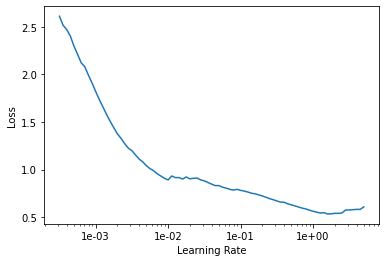

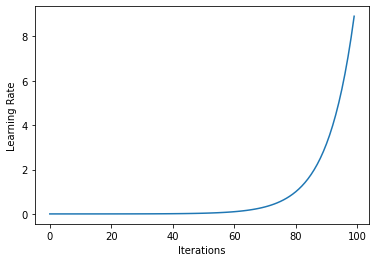

In [ ]:
    #TEST 3 - Densenet 4000 systems optimised hyperparameters (Bayesian)
def fit_with_1(lr, mom, wd):
  folder = 'raw_data_transfering_200_'
  d_type = d_type_opt[0]
  seed = str(1111)
  batch_size = 120
  databunch = prepare_datasets(folder, d_type, seed, batch_size=batch_size, binning=False, bin_size=3, skip_amount=0, extr=True)

  learn = cnn_learner(databunch, models.densenet121, metrics=[accuracy], loss_func=torch.nn.CrossEntropyLoss(), opt_func=optim.SGD, pretrained=False)
  learn.model[0][0] = nn.Conv2d(20, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  learn.model[1][8] = nn.Linear(in_features=512, out_features=n_labels, bias=True)

  learn.fit_one_cycle(1, max_lr=lr)
  learn.recorder.plot_losses()
  acc = float(learn.validate(learn.data.valid_dl)[1])

  print("Accuracy:" + str(acc*100))
  return acc

pbounds = {'lr': (1e-2, 1e+1), 'mom':(0, 0.99), 'wd':(1e-4, 1)}
result = optimise_bayesian(pbounds, fit_with_1)

print("result:", result)

folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, extr=True, batch_size=120)

In [ ]:
local_tests["TEST 3"] = [train_with_parameters(100,lr=best_lr,mom=best_mom, weight_decay=best_weight_decay, epoch_chunk=100)]

####TEST 4 - Create Custom Learner experiment

In [ ]:
create_custom_learner(folder, d_type, seed)
train_max_epochs(1, 0.1, 0.1, 0.1, 1, save = False)

####TEST 5 - Skipping classes test 

In [ ]:
results = {}

def get_losses_bin_skip(bin_size,skip_amount):
  create_learner(folder,d_type,seed, show_model=False, batch_size=30, binning=True,bin_size=bin_size, skip_amount=skip_amount, save=True)
  epoch_goal = 10
  lr = 1
  mom = 0
  wd = 1
  epoch_chunk = 10
  training_losses,validation_losses = train_max_epochs(epoch_goal,lr,mom,wd,epoch_chunk,save=False)
  results[str(bin_size)+str(skip_amount)] = [training_losses,validation_losses]
  print(results)
get_losses_bin_skip(1,0)
get_losses_bin_skip(1,1)
get_losses_bin_skip(1,2)
get_losses_bin_skip(1,3)
get_losses_bin_skip(1,4)

In [ ]:
import matplotlib.pyplot as plt

print(results['11'][0])

plt.plot(range(len(results['11'][0])), results['11'][0], '-b')
plt.plot(range(len(results['12'][0])), results['12'][0], '-b')
plt.plot(range(len(results['13'][0])), results['13'][0], '-b')
plt.plot(range(len(results['14'][0])), results['14'][0], '-b')

plt.plot(range(len(results['11'][0])), results['11'][1], '-r')
plt.plot(range(len(results['12'][0])), results['12'][1], '-r')
plt.plot(range(len(results['13'][0])), results['13'][1], '-r')
plt.plot(range(len(results['14'][0])), results['14'][1], '-r')

plt.title("Train and Valid Losses for different skipping values")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
local_tests["TEST 5"] = [results]

####TEST 6 - resnet18 4000 systems sys_size=30 default hyperparameters

In [ ]:
    #TEST 6 - Resnet18 4000 systems def hyperparameters
folder   = 'raw_data_30/raw_data_transfering_200_30_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, extr=True, batch_size=120)

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_200_30_training_seed1111/
Number of classes:  17
W18.0-200data_seed1111.csv
W17.75-200data_seed1111.csv


KeyboardInterrupt: ignored

In [ ]:
#local_tests["TEST 6"] = [train_max_epochs(100,lr=1, epoch_chunk=100)]

####TEST 7 - densenet121 4000 systems 30 system size default hyperparameters

In [ ]:
     #TEST 7 - Densenet121 4000 systems def hyperparameters
folder   = 'raw_data_transfering_4000_30_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, extr=True, batch_size=120, model=models.densenet121, model_str='densenet121')

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv


ParserError: ignored

In [ ]:
results = train_max_epochs(100,lr=0.2, epoch_chunk=10)
local_tests["TEST 7"] = [results[0],results[1],results[2]]

Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
convert_to_csv(local_tests["TEST 7"], "TEST 7 Results")

          0         1         2
0  0.566322  0.701496  0.444444
1  0.490479  0.719219  0.444444
2  0.419301  0.739483  0.444444


####TEST 8 - Densenet121 - 4000 systems 20 system size Extreme and one in the middle 

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_transfering_4000_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
W16.8-4000data_seed1111.csv
W16.7-4000data_seed1111.csv
W16.6-4000data_seed1111.csv
W16.5-4000data_seed1111.csv
W16.4-4000data_seed1111.csv
W16.3-4000data_seed1111.csv
W16.2-4000data_seed1111.csv
W16.0-4000data_seed1111.csv
W15.75-4000data_seed1111.csv
W15.5-4000data_seed1111.csv
W15.25-4000data_seed1111.csv
W15.0-4000data_seed1111.csv
No pre-existing data raw_data_transfering_4000_training_seed1111. Saving in dictionary



----
   Taking only specific classes
len labels:      3
len training:    3
len validation:  3
len testing:     3
labels =         ['18.0', '15.0', '16.4']
----





epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


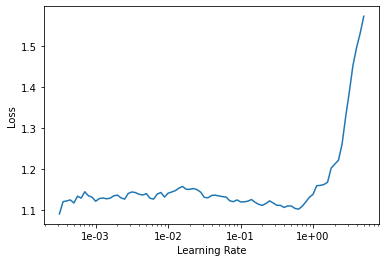

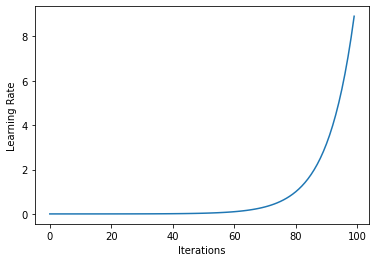

In [ ]:
     #TEST 8 - Densenet121 4000 systems 20 system size def hyperparameters (3 classes, extremised with one in the middle)
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, extr=False, batch_size=120, model=models.densenet121, model_str='densenet121', inc_spec_features=[0,-1,9])


Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,1.129618,1.009987,0.491929,01:23
1,1.112935,0.998505,0.502018,01:23
2,1.087863,0.997852,0.510896,01:28
3,1.050056,0.992229,0.512914,01:22
4,1.052947,0.990726,0.519370,01:23
5,1.070694,0.985484,0.519774,01:23
6,1.047117,0.978314,0.523002,01:23
7,1.032451,0.970182,0.526231,01:23
8,1.015544,0.960841,0.527038,01:24
9,1.010032,0.955826,0.533495,01:28


epoch,train_loss,valid_loss,accuracy,time
0,1.129618,1.009987,0.491929,01:23
1,1.112935,0.998505,0.502018,01:23
2,1.087863,0.997852,0.510896,01:28
3,1.050056,0.992229,0.512914,01:22
4,1.052947,0.990726,0.519370,01:23
5,1.070694,0.985484,0.519774,01:23
6,1.047117,0.978314,0.523002,01:23
7,1.032451,0.970182,0.526231,01:23
8,1.015544,0.960841,0.527038,01:24
9,1.010032,0.955826,0.533495,01:28


/content/drive/MyDrive/ModelStages/CONV2D-densenet121metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_training/epochs-100-max_lr=0.2-mom=0
losses:  [1.1296175718307495, 1.1129345893859863, 1.0878630876541138, 1.050055742263794, 1.0529474020004272, 1.0706939697265625, 1.047116756439209, 1.032450795173645, 1.0155441761016846, 1.0100317001342773, 1.0017322301864624, 0.9775595664978027, 0.9647238254547119, 0.9335319399833679, 0.9203941822052002, 0.8867690563201904, 0.8904598951339722, 0.8661508560180664, 0.8470483422279358, 0.8314380049705505, 0.8088221549987793, 0.8030959367752075, 0.7860974073410034, 0.7721935510635376, 0.754291296005249, 0.741214394569397, 0.7383776903152466, 0.7180649042129517, 0.7041743397712708, 0.6888471245765686, 0.6784995198249817, 0.6778613924980164, 0.6612985134124756, 0.6432445049285889, 0.6319498419761658, 0.6149983406066895, 0.608005166053772, 0.5958723425865173, 0.5798434019088745, 0.5805909633636475, 0.5641471147537231

NameError: ignored

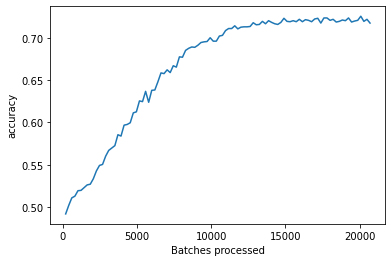

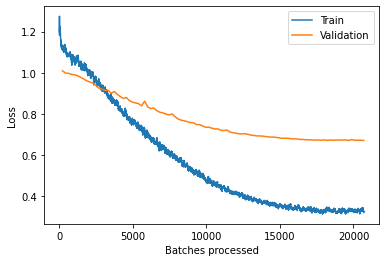

In [ ]:
local_tests["TEST 8"] = [train_max_epochs(100,lr=0.2, epoch_chunk=100)]

####TEST 9 - Resnet18 4000 systems def hyperparameters Extreme and one in the middle

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/
Number of classes:  3
Included:  W18.0-4000data_seed1111.csv
Skipped:  W17.75-4000data_seed1111.csv
Skipped:  W17.5-4000data_seed1111.csv
Skipped:  W17.25-4000data_seed1111.csv
Skipped:  W17.0-4000data_seed1111.csv
Skipped:  W16.8-4000data_seed1111.csv
Skipped:  W16.7-4000data_seed1111.csv
Skipped:  W16.6-4000data_seed1111.csv
Skipped:  W16.5-4000data_seed1111.csv
Included:  W16.4-4000data_seed1111.csv
Skipped:  W16.3-4000data_seed1111.csv
Skipped:  W16.2-4000data_seed1111.csv
Skipped:  W16.0-4000data_seed1111.csv
Skipped:  W15.75-4000data_seed1111.csv
Skipped:  W15.5-4000data_seed1111.csv
Skipped:  W15.25-4000data_seed1111.csv
Included:  W15.0-4000data_seed1111.csv


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training_1111’: File exists


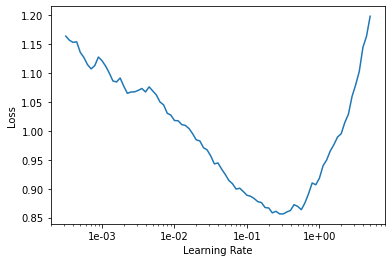

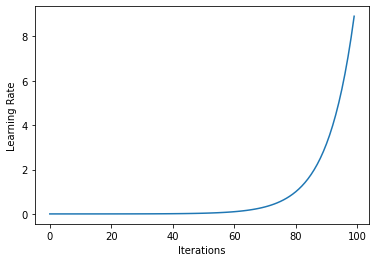

In [ ]:
     #TEST 9 - Resnet18 4000 systems def hyperparameters (Extreme and one in the middle)
folder   = 'raw_data_transfering_4000_30_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, extr=False, batch_size=1024, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9])

Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,1.070156,0.902657,0.563509,04:16
1,0.898184,0.815998,0.619777,04:09
2,0.799103,0.792248,0.633844,04:17


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-3-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459]
validation_losses:  [0.9026573, 0.8159981, 0.79224813]
          0         1         2
0  1.070156  0.902657  0.633844
1  0.898184  0.815998  0.633844
2  0.799103  0.792248  0.633844
Best training so far:  3


epoch,train_loss,valid_loss,accuracy,time
0,0.788275,0.752089,0.667770,04:08
1,0.683644,0.694837,0.699628,04:06
2,0.576695,0.674556,0.714936,04:03


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-6-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558]
          0         1         2
0  1.070156  0.902657  0.633844
1  0.898184  0.815998  0.633844
2  0.799103  0.792248  0.633844
3  0.788275  0.752089  0.714936
4  0.683644  0.694837  0.714936
5  0.576695  0.674556  0.714936
Best training so far:  6


epoch,train_loss,valid_loss,accuracy,time
0,0.568819,0.658476,0.721969,04:05
1,0.475257,0.620161,0.746794,04:11
2,0.402477,0.593774,0.760033,04:03


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-9-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774]
          0         1         2
0  1.070156  0.902657  0.633844
1  0.898184  0.815998  0.633844
2  0.799103  0.792248  0.633844
3  0.788275  0.752089  0.714936
4  0.683644  0.694837  0.714936
5  0.576695  0.674556  0.714936
6  0.568819  0.658476  0.760033
7  0.475257  0.620161  0.760033
8  0.402477  0.593774  0.760033
Best training so far:  9


epoch,train_loss,valid_loss,accuracy,time
0,0.367408,0.580909,0.764584,04:03
1,0.309068,0.561740,0.779065,04:01
2,0.248161,0.556589,0.780306,04:07


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-12-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103  0.792248  0.633844
3   0.788275  0.752089  0.714936
4   0.683644  0.694837  0.714936
5   0.576695  0.674556  0.714936
6   0.568819  0.658476  0.760033
7   0.475257  0.620161  0.760033
8   0.402477  0.593774  0.760033
9   0.367408  0.580909  0.780306
10  0.309068  0.561740  0.780306
11  0.248161  0.556589  0.780306
Best training so far:  12


epoch,train_loss,valid_loss,accuracy,time
0,0.227459,0.564012,0.779479,04:13
1,0.178026,0.547091,0.785685,04:12
2,0.145536,0.548686,0.791063,04:13


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-15-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103  0.792248  0.633844
3   0.788275  0.752089  0.714936
4   0.683644  0.694837  0.714936
5   0.576695  0.674556  0.714936
6   0.568819  0.658476  0.760033
7   0.475257  0.620161  0.760033
8   0.402477  0.593774  0.760033
9   0.367408  0.580909  0.780306
10  0.309068  0.561740  0.780306
11  0.248161  0.556589  0.780306
12  0.227459  0.564012  0.791063
13  0.178026  0.547091  0.791063
14 

epoch,train_loss,valid_loss,accuracy,time
0,0.133730,0.558102,0.790650,04:12
1,0.107540,0.571181,0.784030,04:10
2,0.082710,0.576352,0.783202,04:03


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-18-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653, 0.1337299942970276, 0.10754048824310303, 0.08271024376153946]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686, 0.5581024, 0.57118106, 0.576352]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103  0.792248  0.633844
3   0.788275  0.752089  0.714936
4   0.683644  0.694837  0.714936
5   0.576695  0.674556  0.714936
6   0.568819  0.658476  0.760033
7   0.475257  0.620161  0.760033
8   0.402477  0.593774  0.760033
9   0.367408  0.580909  0.780306
10  0.309068  0.561740  0.780306
11  0.2

epoch,train_loss,valid_loss,accuracy,time
0,0.070460,0.604088,0.781547,04:04
1,0.058910,0.612292,0.783202,04:09
2,0.042544,0.611853,0.782789,04:12


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-21-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653, 0.1337299942970276, 0.10754048824310303, 0.08271024376153946, 0.0704595074057579, 0.058909688144922256, 0.04254376143217087]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686, 0.5581024, 0.57118106, 0.576352, 0.6040884, 0.6122923, 0.6118529]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103  0.792248  0.633844
3   0.788275  0.752089  0.714936
4   0.683644  0.694837  0.714936
5   0.576695  0.674556  0.714936
6   0.568819  0.658476  0.760033
7   0.475257  0.620161  0.760033
8   0.4024

epoch,train_loss,valid_loss,accuracy,time
0,0.043808,0.642895,0.788581,04:11
1,0.036996,0.651933,0.779065,04:11
2,0.029148,0.658196,0.779479,04:13


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-24-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653, 0.1337299942970276, 0.10754048824310303, 0.08271024376153946, 0.0704595074057579, 0.058909688144922256, 0.04254376143217087, 0.04380759596824646, 0.0369955413043499, 0.02914832904934883]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686, 0.5581024, 0.57118106, 0.576352, 0.6040884, 0.6122923, 0.6118529, 0.642895, 0.6519334, 0.65819556]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103  0.792248  0.633844
3   0.788275  0.752089  0.714936
4   0.683644  0.694837  0.714936
5   0.576695  

epoch,train_loss,valid_loss,accuracy,time
0,0.025939,0.663695,0.777410,04:22
1,0.025914,0.681137,0.788995,04:10
2,0.020922,0.676573,0.784443,04:11


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-27-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653, 0.1337299942970276, 0.10754048824310303, 0.08271024376153946, 0.0704595074057579, 0.058909688144922256, 0.04254376143217087, 0.04380759596824646, 0.0369955413043499, 0.02914832904934883, 0.02593904174864292, 0.025914374738931656, 0.020922254770994186]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686, 0.5581024, 0.57118106, 0.576352, 0.6040884, 0.6122923, 0.6118529, 0.642895, 0.6519334, 0.65819556, 0.66369545, 0.68113726, 0.6765725]
           0         1         2
0   1.070156  0.902657  0.633844
1   0.898184  0.815998  0.633844
2   0.799103 

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.018658,0.690032,0.781961,04:11
1,0.020073,0.719904,0.783616,04:10
2,0.015219,0.701928,0.787340,04:09


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_4000_30_training/epochs-30-max_lr=0.2-mom=0


losses:  [1.0701559782028198, 0.8981838822364807, 0.7991025447845459, 0.7882745265960693, 0.6836441159248352, 0.5766945481300354, 0.5688194632530212, 0.47525712847709656, 0.40247660875320435, 0.3674080967903137, 0.30906757712364197, 0.24816052615642548, 0.2274593710899353, 0.1780261993408203, 0.14553560316562653, 0.1337299942970276, 0.10754048824310303, 0.08271024376153946, 0.0704595074057579, 0.058909688144922256, 0.04254376143217087, 0.04380759596824646, 0.0369955413043499, 0.02914832904934883, 0.02593904174864292, 0.025914374738931656, 0.020922254770994186, 0.01865849643945694, 0.02007341757416725, 0.015218946151435375]
validation_losses:  [0.9026573, 0.8159981, 0.79224813, 0.7520889, 0.6948368, 0.6745558, 0.6584762, 0.62016076, 0.593774, 0.58090895, 0.5617404, 0.55658877, 0.564012, 0.5470913, 0.548686, 0.5581024, 0.57118106, 0.576352, 0.6040884, 0.6122923, 0.6118529, 0.642895, 0.6519334, 0.65819556, 0.66369545, 0.68113726, 0.6765725, 0.69003165, 0.71990377, 0.70192826]
           0

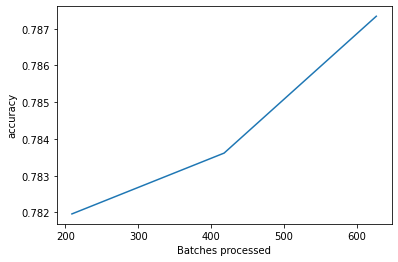

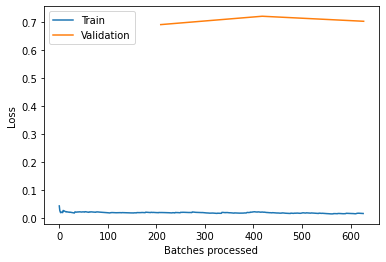

In [ ]:
results = train_max_epochs(30,lr=0.2, epoch_chunk=3, csv_name="TEST 9 Results")

####TEST 10 - Resnet18 4000 systems def hyperparameters Extreme and two in the middle

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/
Number of classes:  4
Included:  W18.0-4000data_seed1111.csv
Skipped:  W17.75-4000data_seed1111.csv
Skipped:  W17.5-4000data_seed1111.csv
Skipped:  W17.25-4000data_seed1111.csv
Skipped:  W17.0-4000data_seed1111.csv
Skipped:  W16.8-4000data_seed1111.csv
Included:  W16.7-4000data_seed1111.csv
Skipped:  W16.6-4000data_seed1111.csv
Skipped:  W16.5-4000data_seed1111.csv
Skipped:  W16.4-4000data_seed1111.csv
Skipped:  W16.3-4000data_seed1111.csv
Included:  W16.2-4000data_seed1111.csv
Skipped:  W16.0-4000data_seed1111.csv
Skipped:  W15.75-4000data_seed1111.csv
Skipped:  W15.5-4000data_seed1111.csv
Skipped:  W15.25-4000data_seed1111.csv
Included:  W15.0-4000data_seed1111.csv


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


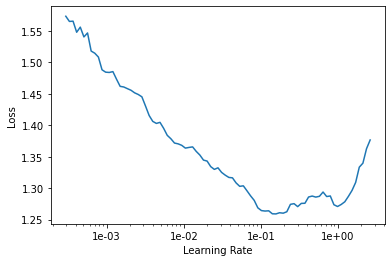

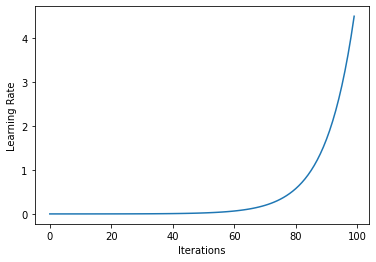

In [ ]:
     #TEST 10 - Resnet18 4000 systems def hyperparameters Quarters (first class, last class and two in the middle of equal separation)
folder   = 'raw_data_transfering_4000_30_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, extr=False, batch_size=1024, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

In [ ]:
results = train_max_epochs(30,lr=0.4, epoch_chunk=3, csv_name="TEST 10 Results")

Best training so far:  0


epoch,train_loss,valid_loss,accuracy,time
0,1.386302,1.236268,0.419982,06:08
1,1.224215,1.136081,0.495529,06:12


####TEST 11 - Resnet18 4000 systems system size 20 Extremes and one in the middle

folder for prep_data:  raw_data_transfering_200_30_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_200_30_training_seed1111/
Number of classes:  3
Included:  W18.0-200data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_200_30_training_seed1111/W18.0-200data_seed1111.csv
Skipped:  W17.75-200data_seed1111.csv
Skipped:  W17.5-200data_seed1111.csv
Skipped:  W17.25-200data_seed1111.csv
Skipped:  W17.0-200data_seed1111.csv
Skipped:  W16.8-200data_seed1111.csv
Skipped:  W16.7-200data_seed1111.csv
Skipped:  W16.6-200data_seed1111.csv
Skipped:  W16.5-200data_seed1111.csv
Included:  W16.4-200data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_200_30_training_seed1111/W16.4-200data_seed1111.csv
Skipped:  W16.3-200data_seed1111.csv
Skipped:  W16.2-200data_seed1111.csv
Skipped:  W16.0-200data_seed1111.csv
Skipped:  W15.75-200data_seed1111.csv
Skipped:  W15

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.24168984496352133


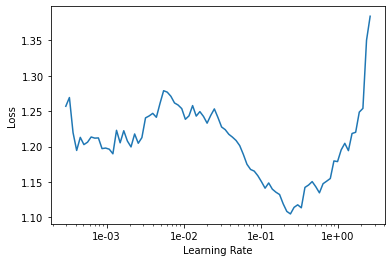

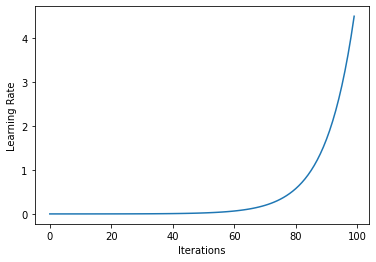

In [ ]:
     #TEST 11 - Resnet18 4000 systems size 20 def hyperparameters (Extreme and one in the middle)
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, extr=False, show_model=True, batch_size=150, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9])

In [ ]:
results = train_max_epochs(30,lr=0.2, epoch_chunk=3, csv_name="TEST 11 Results")

####TEST 12 - CUSTOM_ARCH 4000 systems system size 30 Extremes

folder for prep_data:  raw_data_transfering_200_30_
Found pre-loaded data raw_data_30/raw_data_transfering_200_30_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





---------
   Length of training set:  2
   Length of validation set:  2
   Length of testing set:  2
---------




#!! CHANGING THE NETWORK TO CUSTOM !!#


Saving the model as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=30-ntrain=raw_data_transfering_200_30_training_1111
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/30’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/30/2’: File exists
Model len:  10
Layer:      Conv3d(1, 20, kernel_size=(5, 5, 5), stride=(1, 1, 1))
Layer:      ReLU()
Layer:      Conv3d(20, 20, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(4, 4, 4))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.00012415934136291777


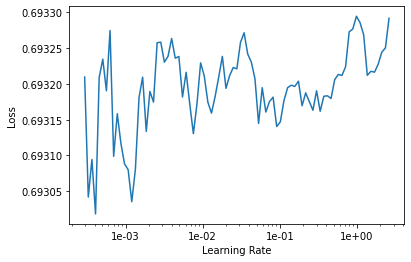

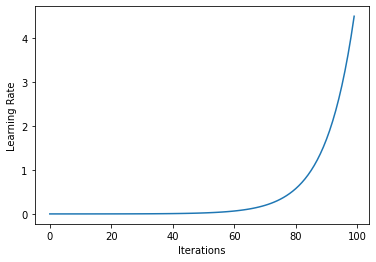

In [ ]:
     #TEST 12 - Resnet18 4000 systems size 30 def hyperparameters Extreme
folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

'''
network_arch = [    #Custom Network Architecture
                nn.Conv3d(1,64,(5,5,5),1,padding=False),
                nn.ReLU(),
                nn.Conv3d(64,64,(5,5,5),1,padding=4),
                nn.ReLU(),
                nn.MaxPool3d(2,2),
                nn.Dropout(p=0.1),
                nn.Conv3d(64,96,(3,3,3),1,padding=False),
                nn.ReLU(),
                nn.Conv3d(96,96,(3,3,3),1,padding=2),
                nn.ReLU(),
                nn.MaxPool3d(2,2),
                nn.Dropout(p=0.1),
                nn.Conv3d(96,128,(3,3,3),1,padding=False),
                nn.ReLU(),
                nn.Conv3d(128,128,(3,3,3),1,padding=2),
                nn.ReLU(),
                nn.MaxPool3d(2,2),
                nn.Dropout(p=0.1),
                nn.Flatten(),
                nn.Linear(in_features=128*3*3*3,out_features=1024),
                nn.Dropout(p=0.1),
                nn.Linear(in_features=1024,out_features=2)               
]
'''
network_arch = [    #Custom Network Architecture
                nn.Conv3d(1,20,(5,5,5),1,padding=False),
                nn.ReLU(),
                nn.Conv3d(20,20,(5,5,5),1,padding=4),
                nn.ReLU(),
                nn.MaxPool3d(2,2),
                nn.Dropout(p=0.1),
                nn.Flatten(),
                nn.Linear(in_features=20*15*15*15,out_features=100),
                nn.Dropout(p=0.1),
                nn.Linear(in_features=100,out_features=2)               
]
create_learner(folder, d_type, seed, sys_size, show_model=True, extr=True, batch_size=30, model=models.resnet18, model_str='Ohtsuki', arch=network_arch)

In [ ]:
train_max_epochs(30, lr=0.1, epoch_chunk=1, load=True, csv_name='TEST 12 - Custom Architecture (Ohtsuki)')

Number of batches =  6
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-0
Best training so far:  0
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693140,0.692911,0.540541,02:13


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.1-mom=0


Result of validate (train):  [0.6931696, tensor(0.5000)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.49666666984558105


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057]
validation_losses:  [0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.1-mom=0
Best training so far:  1
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693189,0.692911,0.540541,02:20


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.1-mom=0


Result of validate (train):  [0.6931481, tensor(0.5033)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.49666666984558105


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081]
validation_losses:  [0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.1-mom=0
Best training so far:  2
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693151,0.692911,0.540541,02:20


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.1-mom=0


Result of validate (train):  [0.69319224, tensor(0.4967)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.4933333396911621


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081, 0.6931508779525757]
validation_losses:  [0.69291055, 0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.1-mom=0
Best training so far:  3
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693123,0.692911,0.540541,02:18


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.1-mom=0


Result of validate (train):  [0.69319165, tensor(0.4967)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.49000000953674316


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081, 0.6931508779525757, 0.6931226253509521]
validation_losses:  [0.69291055, 0.69291055, 0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.1-mom=0
Best training so far:  4
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693182,0.692911,0.540541,02:16


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.1-mom=0


Result of validate (train):  [0.6931725, tensor(0.5000)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.4933333396911621


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081, 0.6931508779525757, 0.6931226253509521, 0.6931819319725037]
validation_losses:  [0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.1-mom=0
Best training so far:  5
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693195,0.692911,0.540541,02:17


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.1-mom=0


Result of validate (train):  [0.6931906, tensor(0.4967)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.5


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081, 0.6931508779525757, 0.6931226253509521, 0.6931819319725037, 0.6931954622268677]
validation_losses:  [0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.1-mom=0
Best training so far:  6
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.693175,0.692911,0.540541,02:19


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.1-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.1-mom=0


Result of validate (train):  [0.6931914, tensor(0.4967)]


Result of validate (valid):  [0.69291055, tensor(0.5405)]


train_acc =  0.4933333396911621


valid_acc =  0.5405405163764954
losses:  [0.6931402683258057, 0.6931887269020081, 0.6931508779525757, 0.6931226253509521, 0.6931819319725037, 0.6931954622268677, 0.6931749582290649]
validation_losses:  [0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055, 0.69291055]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-Ohtsuki-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=50-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.1-mom=0
Best training so far:  7
Using (max) lr of:  0.1
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

####TEST 13 - Resnet18 4000 systems size 20 def hyperparameters Extreme and two in the middle

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_200_training_seed1111/
Number of classes:  4
Included:  W18.0-200data_seed1111.csv
20
Skipped:  W17.75-200data_seed1111.csv
Skipped:  W17.5-200data_seed1111.csv
Skipped:  W17.25-200data_seed1111.csv
Skipped:  W17.0-200data_seed1111.csv
Skipped:  W16.8-200data_seed1111.csv
Included:  W16.7-200data_seed1111.csv
20
Skipped:  W16.6-200data_seed1111.csv
Skipped:  W16.5-200data_seed1111.csv
Skipped:  W16.4-200data_seed1111.csv
Skipped:  W16.3-200data_seed1111.csv
Included:  W16.2-200data_seed1111.csv
20
Skipped:  W16.0-200data_seed1111.csv
Skipped:  W15.75-200data_seed1111.csv
Skipped:  W15.5-200data_seed1111.csv
Skipped:  W15.25-200data_seed1111.csv
Included:  W15.0-200data_seed1111.csv
20
Model len:  2
Layer:      Sequential(
  (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_200_training_1111’: File exists


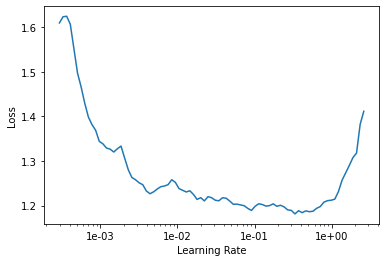

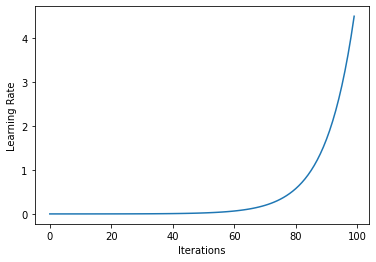

In [ ]:
     #TEST 13 - Resnet18 4000 systems size 20 def hyperparameters Extreme and two in the middle
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, show_model=True, extr=False, batch_size=120, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

In [ ]:
results = train_max_epochs(30,lr=1e-4, epoch_chunk=5, csv_name="TEST 13 - Resnet18 4000 systems size 20 def hyperparameters Extreme and two in the middle")

NameError: ignored

####TEST 14 - Making sure it all works 

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_1000_30_training_seed1111/
Number of classes:  17
W18.0-1000data_seed1111.csv
len files:  16
Included:  W18.0-1000data_seed1111.csv
30
W17.75-1000data_seed1111.csv
len files:  16
Skipped:  W17.75-1000data_seed1111.csv
W17.5-1000data_seed1111.csv
len files:  16
Skipped:  W17.5-1000data_seed1111.csv
W17.25-1000data_seed1111.csv
len files:  16
Skipped:  W17.25-1000data_seed1111.csv
W17.0-1000data_seed1111.csv
len files:  16
Skipped:  W17.0-1000data_seed1111.csv
W16.8-1000data_seed1111.csv
len files:  16
Skipped:  W16.8-1000data_seed1111.csv
W16.7-1000data_seed1111.csv
len files:  16
Skipped:  W16.7-1000data_seed1111.csv
W16.6-1000data_seed1111.csv
len files:  16
Skipped:  W16.6-1000data_seed1111.csv
W16.5-1000data_seed1111.csv
len files:  16
Skipped:  W16.5-1000data_seed1111.csv
W16.4-1000data_seed1111.csv
len files:  16
Skipped:  W16.4-1000data_seed1111.csv
W16.3-1000data_seed1111.csv
len files:  16
Skipp

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_30_training_1111’: File exists


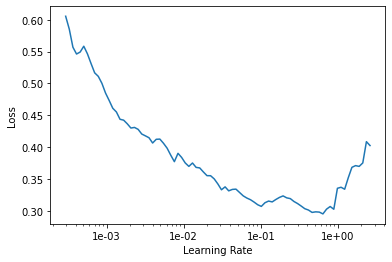

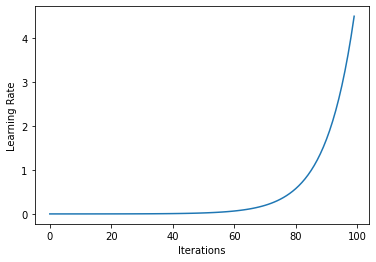

In [ ]:
     #TEST 14
folder   = 'raw_data_transfering_1000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, show_model=True, extr=True, batch_size=40, model=models.resnet18, model_str='resnet18')

Number of batches =  37
no load - epoch chunk =  100


epoch,train_loss,valid_loss,accuracy,time
0,0.798019,0.774175,0.475325,00:51
1,0.765934,0.824804,0.475325,00:51
2,0.725801,0.624731,0.670130,00:51
3,0.687145,0.587260,0.675325,00:49
4,0.660827,0.563859,0.701299,00:49
5,0.632369,0.539826,0.716883,00:49
6,0.599585,0.520805,0.727273,00:49
7,0.570987,0.499767,0.750649,00:52
8,0.549175,0.473980,0.768831,00:50
9,0.506427,0.451567,0.792208,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.798019,0.774175,0.475325,00:51
1,0.765934,0.824804,0.475325,00:51
2,0.725801,0.624731,0.670130,00:51
3,0.687145,0.587260,0.675325,00:49
4,0.660827,0.563859,0.701299,00:49
5,0.632369,0.539826,0.716883,00:49
6,0.599585,0.520805,0.727273,00:49
7,0.570987,0.499767,0.750649,00:52
8,0.549175,0.473980,0.768831,00:50
9,0.506427,0.451567,0.792208,00:49


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-100-max_lr=0.3-mom=0


ACC =  0.9090909361839294
losses:  [0.7980185747146606, 0.7659338116645813, 0.7258009314537048, 0.6871452927589417, 0.6608269810676575, 0.6323685646057129, 0.5995854139328003, 0.5709865093231201, 0.5491753220558167, 0.5064265727996826, 0.47522929310798645, 0.44145533442497253, 0.40348753333091736, 0.3750532865524292, 0.3397233188152313, 0.30811968445777893, 0.26254573464393616, 0.23692569136619568, 0.20904645323753357, 0.18421943485736847, 0.15635524690151215, 0.1274479180574417, 0.11015167832374573, 0.09331288933753967, 0.07905805110931396, 0.06909029185771942, 0.05439215898513794, 0.044697392731904984, 0.03830225020647049, 0.0344947911798954, 0.030363354831933975, 0.026492489501833916, 0.02421358972787857, 0.01963672786951065, 0.01887468248605728, 0.016518456861376762, 0.014679833315312862, 0.014126647263765335, 0.013026361353695393, 0.011520319618284702, 0.011128153651952744, 0.009843294508755207, 0.011460683308541775, 0.010312057100236416, 0.008854201063513756, 0.007701378315687179

([0.7980185747146606,
  0.7659338116645813,
  0.7258009314537048,
  0.6871452927589417,
  0.6608269810676575,
  0.6323685646057129,
  0.5995854139328003,
  0.5709865093231201,
  0.5491753220558167,
  0.5064265727996826,
  0.47522929310798645,
  0.44145533442497253,
  0.40348753333091736,
  0.3750532865524292,
  0.3397233188152313,
  0.30811968445777893,
  0.26254573464393616,
  0.23692569136619568,
  0.20904645323753357,
  0.18421943485736847,
  0.15635524690151215,
  0.1274479180574417,
  0.11015167832374573,
  0.09331288933753967,
  0.07905805110931396,
  0.06909029185771942,
  0.05439215898513794,
  0.044697392731904984,
  0.03830225020647049,
  0.0344947911798954,
  0.030363354831933975,
  0.026492489501833916,
  0.02421358972787857,
  0.01963672786951065,
  0.01887468248605728,
  0.016518456861376762,
  0.014679833315312862,
  0.014126647263765335,
  0.013026361353695393,
  0.011520319618284702,
  0.011128153651952744,
  0.009843294508755207,
  0.011460683308541775,
  0.0103120571

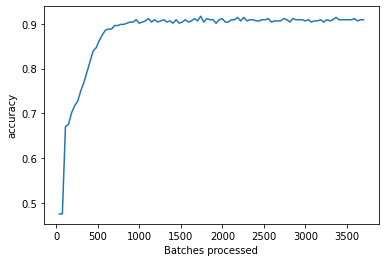

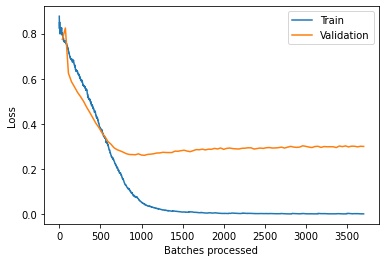

In [ ]:
train_max_epochs(100,lr=0.3, epoch_chunk=100, load=False, csv_name='Big Test of extreme classes')

####TEST 15 - Making sure it all works 2

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_1000_30_training_seed1111/
Number of classes:  17
W18.0-1000data_seed1111.csv
len files:  16
Included:  W18.0-1000data_seed1111.csv
30
W17.75-1000data_seed1111.csv
len files:  16
Skipped:  W17.75-1000data_seed1111.csv
W17.5-1000data_seed1111.csv
len files:  16
Skipped:  W17.5-1000data_seed1111.csv
W17.25-1000data_seed1111.csv
len files:  16
Skipped:  W17.25-1000data_seed1111.csv
W17.0-1000data_seed1111.csv
len files:  16
Skipped:  W17.0-1000data_seed1111.csv
W16.8-1000data_seed1111.csv
len files:  16
Skipped:  W16.8-1000data_seed1111.csv
W16.7-1000data_seed1111.csv
len files:  16
Skipped:  W16.7-1000data_seed1111.csv
W16.6-1000data_seed1111.csv
len files:  16
Skipped:  W16.6-1000data_seed1111.csv
W16.5-1000data_seed1111.csv
len files:  16
Skipped:  W16.5-1000data_seed1111.csv
W16.4-1000data_seed1111.csv
len files:  16
Skipped:  W16.4-1000data_seed1111.csv
W16.3-1000data_seed1111.csv
len files:  16
Skipp

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.5154497145169031
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_30_training_1111’: File exists


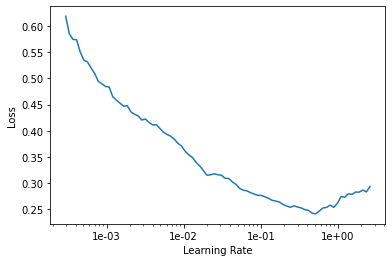

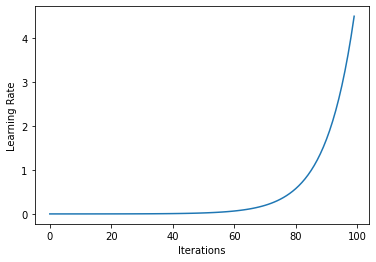

In [ ]:
     #TEST 15
folder   = 'raw_data_transfering_1000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=True, batch_size=40, model=models.resnet18, model_str='resnet18')

In [ ]:
train_max_epochs(100, lr='BEST', epoch_chunk=10, load=False, csv_name='TEST 15 - Big Test of extreme classes')

Number of batches =  37
no load - epoch chunk =  10
Using (max) lr of:  0.5154497145169031


epoch,train_loss,valid_loss,accuracy,time
0,0.818738,0.698015,0.466830,00:44
1,0.705190,0.865301,0.484029,00:44
2,0.604153,0.621003,0.665848,00:44
3,0.513046,0.477507,0.746929,00:44
4,0.426613,0.447296,0.793612,00:44
5,0.359055,0.446169,0.781327,00:44
6,0.297066,0.429494,0.791155,00:44
7,0.257189,0.421751,0.798526,00:44
8,0.230196,0.428224,0.796069,00:44
9,0.219557,0.420338,0.805897,00:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-10-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.1318209, tensor(0.9764)]


Result of validate (valid):  [0.42033824, tensor(0.8059)]


train_acc =  0.9763513803482056


valid_acc =  0.8058968186378479
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059]
validation_losses:  [0.698015, 0.8653015, 0.621003, 0.47750676, 0.447296, 0.44616863, 0.42949438, 0.42175105, 0.42822406, 0.42033824]
Using (max) lr of:  0.5154497145169031


epoch,train_loss,valid_loss,accuracy,time
0,0.202873,0.421501,0.805897,00:44
1,0.207394,0.409638,0.813268,00:44
2,0.189956,0.410937,0.813268,00:44
3,0.156411,0.405640,0.830467,00:44
4,0.129314,0.400288,0.828010,00:44
5,0.104465,0.403913,0.825553,00:44
6,0.089974,0.408182,0.830467,00:44
7,0.078770,0.415382,0.828010,00:44
8,0.070401,0.410643,0.828010,00:44
9,0.062230,0.417557,0.828010,00:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-20-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.02338073, tensor(1.)]


Result of validate (valid):  [0.41755676, tensor(0.8280)]


train_acc =  1.0


valid_acc =  0.828009843826294
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151]
validation_losses:  [0.698015, 0.8653015, 0.621003, 0.47750676, 0.447296, 0.44616863, 0.42949438, 0.42175105, 0.42822406, 0.42033824, 0.4215009, 0.40963817, 0.41093722, 0.40564048, 0.400288, 0.4039134, 0.40818194, 0.41538242, 0.41064334, 0.41755676]
Using (max) lr of:  0.5154497145169031


epoch,train_loss,valid_loss,accuracy,time
0,0.065927,0.400952,0.832924,00:45
1,0.063485,0.402460,0.835381,00:44
2,0.055296,0.408415,0.828010,00:47
3,0.047464,0.422532,0.835381,00:45
4,0.041264,0.439257,0.828010,00:45
5,0.034728,0.433081,0.830467,00:45
6,0.031034,0.446405,0.828010,00:44
7,0.026526,0.445490,0.828010,00:44
8,0.025074,0.433016,0.832924,00:45
9,0.024601,0.429522,0.830467,00:46


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-30-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.006127299, tensor(1.)]


Result of validate (valid):  [0.42952242, tensor(0.8305)]


train_acc =  1.0


valid_acc =  0.8304668068885803
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151, 0.06592664867639542, 0.06348534673452377, 0.0552956648170948, 0.04746442660689354, 0.04126429185271263, 0.03472841903567314, 0.03103449009358883, 0.02652636356651783, 0.025073762983083725, 0.02460096962749958]
validation_losses:  [0.698015, 0.8653015, 0.621003, 0.47750676, 0.447296, 0.44616863, 0.42949438, 0.42175105, 0.42822406, 0.42033824, 0.4215009, 0.40963817, 0.41093722, 0.40564048, 0.400288, 0.4039134, 0.40818194, 0.41538242, 0.41064334, 0.41755676, 0.4009521, 0.40245992, 0.40841466, 0.4225321, 0.43925667, 0.43308118, 0.44640523, 0.445490

epoch,train_loss,valid_loss,accuracy,time
0,0.026800,0.448648,0.828010,00:45
1,0.023318,0.456527,0.832924,00:44
2,0.022273,0.434240,0.837838,00:44
3,0.019653,0.441891,0.837838,00:47
4,0.016253,0.470258,0.830467,00:55
5,0.013715,0.443947,0.832924,00:58
6,0.015448,0.456652,0.832924,00:55
7,0.011632,0.467554,0.830467,00:51
8,0.011067,0.454596,0.837838,00:50
9,0.010667,0.459237,0.832924,00:49


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-40-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.002669226, tensor(1.)]


Result of validate (valid):  [0.45923656, tensor(0.8329)]


train_acc =  1.0


valid_acc =  0.8329238295555115
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151, 0.06592664867639542, 0.06348534673452377, 0.0552956648170948, 0.04746442660689354, 0.04126429185271263, 0.03472841903567314, 0.03103449009358883, 0.02652636356651783, 0.025073762983083725, 0.02460096962749958, 0.02680041827261448, 0.023318493738770485, 0.022273465991020203, 0.019653350114822388, 0.016253380104899406, 0.013715418986976147, 0.015447543002665043, 0.011632166802883148, 0.01106664352118969, 0.010667093098163605]
validation_losses:  [0.698015, 0.8653015, 0.621003, 0.47750676, 0.447296, 0.44616863, 0.42949438, 0.42175105, 0.42822406, 

epoch,train_loss,valid_loss,accuracy,time
0,0.012875,0.461831,0.832924,00:50
1,0.012931,0.466183,0.832924,00:50
2,0.012482,0.448669,0.842752,00:47
3,0.012681,0.478936,0.837838,00:44
4,0.010489,0.513049,0.832924,00:44
5,0.010114,0.464385,0.842752,00:45
6,0.008203,0.471436,0.842752,00:44
7,0.007059,0.461973,0.840295,00:44
8,0.006949,0.458834,0.837838,00:43
9,0.006718,0.474819,0.840295,00:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-50-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.0014558807, tensor(1.)]


Result of validate (valid):  [0.4748192, tensor(0.8403)]


train_acc =  1.0


valid_acc =  0.8402948379516602
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151, 0.06592664867639542, 0.06348534673452377, 0.0552956648170948, 0.04746442660689354, 0.04126429185271263, 0.03472841903567314, 0.03103449009358883, 0.02652636356651783, 0.025073762983083725, 0.02460096962749958, 0.02680041827261448, 0.023318493738770485, 0.022273465991020203, 0.019653350114822388, 0.016253380104899406, 0.013715418986976147, 0.015447543002665043, 0.011632166802883148, 0.01106664352118969, 0.010667093098163605, 0.012874902226030827, 0.012930580414831638, 0.01248228270560503, 0.01268080249428749, 0.010488918051123619, 0.010114456526

epoch,train_loss,valid_loss,accuracy,time
0,0.006668,0.483648,0.837838,00:45
1,0.006928,0.482391,0.842752,00:44
2,0.006102,0.472869,0.837838,00:44
3,0.005718,0.470679,0.842752,00:44
4,0.005327,0.487207,0.837838,00:44
5,0.005634,0.490080,0.842752,00:44
6,0.005399,0.490192,0.842752,00:44
7,0.004678,0.488184,0.842752,00:44
8,0.004554,0.500649,0.837838,00:44
9,0.004046,0.485924,0.840295,00:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-60-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.0007813521, tensor(1.)]


Result of validate (valid):  [0.4859243, tensor(0.8403)]


train_acc =  1.0


valid_acc =  0.8402948379516602
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151, 0.06592664867639542, 0.06348534673452377, 0.0552956648170948, 0.04746442660689354, 0.04126429185271263, 0.03472841903567314, 0.03103449009358883, 0.02652636356651783, 0.025073762983083725, 0.02460096962749958, 0.02680041827261448, 0.023318493738770485, 0.022273465991020203, 0.019653350114822388, 0.016253380104899406, 0.013715418986976147, 0.015447543002665043, 0.011632166802883148, 0.01106664352118969, 0.010667093098163605, 0.012874902226030827, 0.012930580414831638, 0.01248228270560503, 0.01268080249428749, 0.010488918051123619, 0.010114456526

epoch,train_loss,valid_loss,accuracy,time
0,0.007945,0.520392,0.837838,00:44
1,0.004699,0.486992,0.842752,00:44
2,0.004579,0.505110,0.842752,00:45
3,0.004085,0.505169,0.837838,00:45
4,0.004477,0.513536,0.840295,00:45
5,0.004091,0.491481,0.840295,00:45
6,0.003688,0.496636,0.842752,00:44
7,0.003718,0.505416,0.837838,00:44
8,0.003391,0.508091,0.845209,00:44
9,0.002854,0.512758,0.840295,00:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-###TEST###bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-70-max_lr=0.5154497145169031-mom=0


Result of validate (train):  [0.0005496801, tensor(1.)]


Result of validate (valid):  [0.5127582, tensor(0.8403)]


train_acc =  1.0


valid_acc =  0.8402948379516602
losses:  [0.8187379240989685, 0.7051902413368225, 0.6041527390480042, 0.5130457878112793, 0.4266125559806824, 0.3590552508831024, 0.2970661222934723, 0.2571887969970703, 0.23019607365131378, 0.21955657005310059, 0.2028728723526001, 0.20739449560642242, 0.1899556964635849, 0.15641070902347565, 0.12931431829929352, 0.10446545481681824, 0.0899737998843193, 0.07876966148614883, 0.0704008936882019, 0.06223016604781151, 0.06592664867639542, 0.06348534673452377, 0.0552956648170948, 0.04746442660689354, 0.04126429185271263, 0.03472841903567314, 0.03103449009358883, 0.02652636356651783, 0.025073762983083725, 0.02460096962749958, 0.02680041827261448, 0.023318493738770485, 0.022273465991020203, 0.019653350114822388, 0.016253380104899406, 0.013715418986976147, 0.015447543002665043, 0.011632166802883148, 0.01106664352118969, 0.010667093098163605, 0.012874902226030827, 0.012930580414831638, 0.01248228270560503, 0.01268080249428749, 0.010488918051123619, 0.010114456526

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

####TEST 16 - resnet18 L50 extreme and on in middle 1000 systems 30 epochs

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/
Number of classes:  3
Included:  W18.0-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W18.0-1000data_seed1111.csv
50
Skipped:  W17.75-1000data_seed1111.csv
Skipped:  W17.5-1000data_seed1111.csv
Skipped:  W17.25-1000data_seed1111.csv
Skipped:  W17.0-1000data_seed1111.csv
Skipped:  W16.8-1000data_seed1111.csv
Skipped:  W16.7-1000data_seed1111.csv
Skipped:  W16.6-1000data_seed1111.csv
Skipped:  W16.5-1000data_seed1111.csv
Included:  W16.4-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W16.4-1000data_seed1111.csv
50
Skipped:  W16.3-1000data_seed1111.csv
Skipped:  W16.2-1000data_seed1111.csv
Skipped:  W16.0-1000data_seed1111.csv
Skipped:  W15.75-1000data_seed1111.csv
Skipped:  W15.5-1000data_seed1111.csv
Sk

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.46259038683178505
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_50_training_1111’: File exists


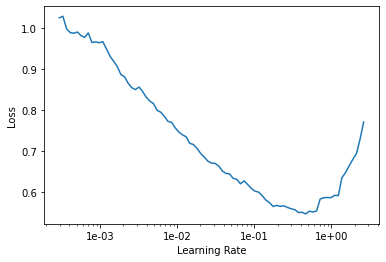

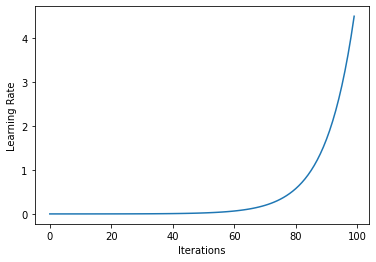

In [ ]:
#TEST 16 - resnet18 L50 extreme and one in middle 1000 systems 30 epochs
folder   = 'raw_data_transfering_1000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=40, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9])

Number of batches =  56
no load - epoch chunk =  1
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.029967,1.866115,0.341709,02:26


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-1-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [1.8955876, tensor(0.3335)]


Result of validate (valid):  [1.8661149, tensor(0.3417)]


train_acc =  0.33348214626312256


valid_acc =  0.34170854091644287
losses:  [1.029967188835144]
validation_losses:  [1.8661149]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.931846,1.019435,0.487437,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-2-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [1.0081992, tensor(0.4955)]


Result of validate (valid):  [1.0194354, tensor(0.4874)]


train_acc =  0.4982142746448517


valid_acc =  0.4874371886253357
losses:  [1.029967188835144, 0.9318464994430542]
validation_losses:  [1.8661149, 1.0194354]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.824567,0.806232,0.631491,02:21


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-3-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.66721255, tensor(0.7179)]


Result of validate (valid):  [0.80623186, tensor(0.6315)]


train_acc =  0.7183035612106323


valid_acc =  0.6314907670021057
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569]
validation_losses:  [1.8661149, 1.0194354, 0.80623186]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.746343,0.772137,0.651591,02:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-4-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.59346837, tensor(0.7710)]


Result of validate (valid):  [0.772137, tensor(0.6516)]


train_acc =  0.7691964507102966


valid_acc =  0.6515913009643555
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.700056,0.737835,0.673367,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-5-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.54134655, tensor(0.8000)]


Result of validate (valid):  [0.7378347, tensor(0.6734)]


train_acc =  0.8008928298950195


valid_acc =  0.6733668446540833
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.614537,0.709710,0.678392,02:21


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-6-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.48410612, tensor(0.8433)]


Result of validate (valid):  [0.70970964, tensor(0.6784)]


train_acc =  0.8424107432365417


valid_acc =  0.6783919334411621
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.590719,0.695885,0.685092,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-7-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.4350801, tensor(0.8647)]


Result of validate (valid):  [0.6958855, tensor(0.6851)]


train_acc =  0.8633928298950195


valid_acc =  0.6850921511650085
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.527850,0.681620,0.691792,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-8-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.38729936, tensor(0.8929)]


Result of validate (valid):  [0.68161994, tensor(0.6918)]


train_acc =  0.8919642567634583


valid_acc =  0.6917923092842102
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.496482,0.669287,0.700167,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-9-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.34729755, tensor(0.9080)]


Result of validate (valid):  [0.6692873, tensor(0.7002)]


train_acc =  0.9075892567634583


valid_acc =  0.7001674771308899
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.445638,0.657222,0.713568,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-10-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.30492714, tensor(0.9308)]


Result of validate (valid):  [0.6572221, tensor(0.7136)]


train_acc =  0.9299107193946838


valid_acc =  0.713567852973938
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.404217,0.648062,0.720268,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-11-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.26708713, tensor(0.9451)]


Result of validate (valid):  [0.64806235, tensor(0.7203)]


train_acc =  0.9450892806053162


valid_acc =  0.7202680110931396
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.368967,0.639145,0.726968,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-12-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.23425636, tensor(0.9652)]


Result of validate (valid):  [0.6391452, tensor(0.7270)]


train_acc =  0.965624988079071


valid_acc =  0.7269681692123413
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.327083,0.644694,0.716918,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-13-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.20499937, tensor(0.9696)]


Result of validate (valid):  [0.6446936, tensor(0.7169)]


train_acc =  0.9700892567634583


valid_acc =  0.7169179320335388
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.300683,0.629655,0.733668,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-14-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.17395104, tensor(0.9804)]


Result of validate (valid):  [0.6296553, tensor(0.7337)]


train_acc =  0.9803571701049805


valid_acc =  0.733668327331543
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.267069,0.628399,0.735343,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-15-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.14815313, tensor(0.9902)]


Result of validate (valid):  [0.62839854, tensor(0.7353)]


train_acc =  0.9901785850524902


valid_acc =  0.7353433966636658
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.246407,0.627415,0.737018,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-16-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.12756023, tensor(0.9915)]


Result of validate (valid):  [0.6274155, tensor(0.7370)]


train_acc =  0.9915178418159485


valid_acc =  0.7370184063911438
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.222361,0.625264,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-17-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.11035556, tensor(0.9951)]


Result of validate (valid):  [0.6252638, tensor(0.7420)]


train_acc =  0.9950892925262451


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.191117,0.619522,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-18-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.096825995, tensor(0.9969)]


Result of validate (valid):  [0.61952186, tensor(0.7420)]


train_acc =  0.996874988079071


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.172565,0.626793,0.735343,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-19-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.08063262, tensor(0.9987)]


Result of validate (valid):  [0.6267926, tensor(0.7353)]


train_acc =  0.9986607432365417


valid_acc =  0.7353433966636658
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.149345,0.611599,0.747069,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-20-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.06764925, tensor(0.9996)]


Result of validate (valid):  [0.6115994, tensor(0.7471)]


train_acc =  0.9995535612106323


valid_acc =  0.7470687031745911
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.132523,0.618115,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-21-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.059185464, tensor(1.)]


Result of validate (valid):  [0.6181147, tensor(0.7420)]


train_acc =  1.0


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.120344,0.624854,0.743719,02:17


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-22-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.05125743, tensor(1.)]


Result of validate (valid):  [0.6248539, tensor(0.7437)]


train_acc =  1.0


valid_acc =  0.7437185645103455
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.101778,0.622506,0.745394,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-23-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.043200593, tensor(1.)]


Result of validate (valid):  [0.622506, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.094044,0.632853,0.740368,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-24-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.03853385, tensor(1.)]


Result of validate (valid):  [0.6328534, tensor(0.7404)]


train_acc =  1.0


valid_acc =  0.7403684854507446
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.087800,0.624732,0.745394,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-25-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.032197922, tensor(1.)]


Result of validate (valid):  [0.6247325, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.079656,0.622361,0.740368,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-26-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.027326932, tensor(1.)]


Result of validate (valid):  [0.62236094, tensor(0.7404)]


train_acc =  1.0


valid_acc =  0.7403684854507446
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.074872,0.634108,0.745394,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-27-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.024004966, tensor(1.)]


Result of validate (valid):  [0.63410753, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.058792,0.632701,0.738693,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-28-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.020880269, tensor(1.)]


Result of validate (valid):  [0.6327007, tensor(0.7387)]


train_acc =  1.0


valid_acc =  0.7386934757232666
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007]
Using (max) lr of:  0.46259038683178505
lr being use

epoch,train_loss,valid_loss,accuracy,time
0,0.068013,0.638700,0.737018,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-29-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.018845938, tensor(1.)]


Result of validate (valid):  [0.63869953, tensor(0.7370)]


train_acc =  1.0


valid_acc =  0.7370184063911438
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534, 0.06801315397024155]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007, 0.63869953]
Using (max) lr of: 

epoch,train_loss,valid_loss,accuracy,time
0,0.054027,0.629127,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-30-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.015730048, tensor(1.)]


Result of validate (valid):  [0.62912667, tensor(0.7420)]


train_acc =  1.0


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534, 0.06801315397024155, 0.05402711406350136]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007, 0.63869953

([1.029967188835144,
  0.9318464994430542,
  0.8245671987533569,
  0.7463432550430298,
  0.7000564336776733,
  0.6145368814468384,
  0.590718686580658,
  0.5278496742248535,
  0.49648186564445496,
  0.4456382989883423,
  0.4042174816131592,
  0.3689674139022827,
  0.32708263397216797,
  0.300682932138443,
  0.2670685350894928,
  0.2464073747396469,
  0.22236140072345734,
  0.19111685454845428,
  0.17256473004817963,
  0.14934533834457397,
  0.13252323865890503,
  0.12034379690885544,
  0.10177778452634811,
  0.09404431283473969,
  0.08779983967542648,
  0.07965587079524994,
  0.07487168908119202,
  0.05879152566194534,
  0.06801315397024155,
  0.05402711406350136],
 [1.8661149,
  1.0194354,
  0.80623186,
  0.772137,
  0.7378347,
  0.70970964,
  0.6958855,
  0.68161994,
  0.6692873,
  0.6572221,
  0.64806235,
  0.6391452,
  0.6446936,
  0.6296553,
  0.62839854,
  0.6274155,
  0.6252638,
  0.61952186,
  0.6267926,
  0.6115994,
  0.6181147,
  0.6248539,
  0.622506,
  0.6328534,
  0.624732

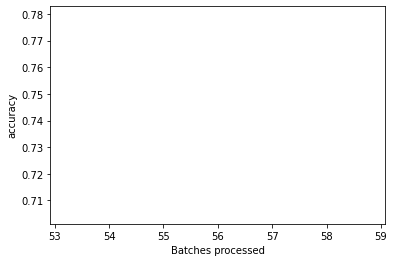

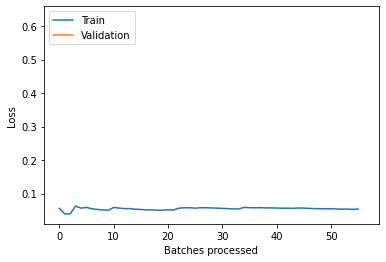

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 16 - resnet18 L50 extreme and one in middle 1000 systems 30 epochs')

####TEST 17 - resnet18 L50 extreme and two in middle 1000 systems 30 epochs

In [ ]:
#TEST 17 - resnet18 L50 extreme and two in middle 1000 systems 30 epochs
folder   = 'raw_data_transfering_1000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=40, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

   Data directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/
Number of classes:  4
Included:  W18.0-1000data_seed1111.csv


KeyboardInterrupt: ignored

Number of batches =  56
no load - epoch chunk =  1
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.029967,1.866115,0.341709,02:26


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-1-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [1.8955876, tensor(0.3335)]


Result of validate (valid):  [1.8661149, tensor(0.3417)]


train_acc =  0.33348214626312256


valid_acc =  0.34170854091644287
losses:  [1.029967188835144]
validation_losses:  [1.8661149]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.931846,1.019435,0.487437,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-2-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [1.0081992, tensor(0.4955)]


Result of validate (valid):  [1.0194354, tensor(0.4874)]


train_acc =  0.4982142746448517


valid_acc =  0.4874371886253357
losses:  [1.029967188835144, 0.9318464994430542]
validation_losses:  [1.8661149, 1.0194354]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.824567,0.806232,0.631491,02:21


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-3-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.66721255, tensor(0.7179)]


Result of validate (valid):  [0.80623186, tensor(0.6315)]


train_acc =  0.7183035612106323


valid_acc =  0.6314907670021057
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569]
validation_losses:  [1.8661149, 1.0194354, 0.80623186]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.746343,0.772137,0.651591,02:44


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-4-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.59346837, tensor(0.7710)]


Result of validate (valid):  [0.772137, tensor(0.6516)]


train_acc =  0.7691964507102966


valid_acc =  0.6515913009643555
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.700056,0.737835,0.673367,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-5-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.54134655, tensor(0.8000)]


Result of validate (valid):  [0.7378347, tensor(0.6734)]


train_acc =  0.8008928298950195


valid_acc =  0.6733668446540833
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.614537,0.709710,0.678392,02:21


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-6-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.48410612, tensor(0.8433)]


Result of validate (valid):  [0.70970964, tensor(0.6784)]


train_acc =  0.8424107432365417


valid_acc =  0.6783919334411621
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.590719,0.695885,0.685092,02:20


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-7-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.4350801, tensor(0.8647)]


Result of validate (valid):  [0.6958855, tensor(0.6851)]


train_acc =  0.8633928298950195


valid_acc =  0.6850921511650085
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.527850,0.681620,0.691792,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-8-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.38729936, tensor(0.8929)]


Result of validate (valid):  [0.68161994, tensor(0.6918)]


train_acc =  0.8919642567634583


valid_acc =  0.6917923092842102
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.496482,0.669287,0.700167,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-9-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.34729755, tensor(0.9080)]


Result of validate (valid):  [0.6692873, tensor(0.7002)]


train_acc =  0.9075892567634583


valid_acc =  0.7001674771308899
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.445638,0.657222,0.713568,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-10-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.30492714, tensor(0.9308)]


Result of validate (valid):  [0.6572221, tensor(0.7136)]


train_acc =  0.9299107193946838


valid_acc =  0.713567852973938
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.404217,0.648062,0.720268,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-11-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.26708713, tensor(0.9451)]


Result of validate (valid):  [0.64806235, tensor(0.7203)]


train_acc =  0.9450892806053162


valid_acc =  0.7202680110931396
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.368967,0.639145,0.726968,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-12-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.23425636, tensor(0.9652)]


Result of validate (valid):  [0.6391452, tensor(0.7270)]


train_acc =  0.965624988079071


valid_acc =  0.7269681692123413
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.327083,0.644694,0.716918,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-13-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.20499937, tensor(0.9696)]


Result of validate (valid):  [0.6446936, tensor(0.7169)]


train_acc =  0.9700892567634583


valid_acc =  0.7169179320335388
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.300683,0.629655,0.733668,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-14-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.17395104, tensor(0.9804)]


Result of validate (valid):  [0.6296553, tensor(0.7337)]


train_acc =  0.9803571701049805


valid_acc =  0.733668327331543
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.267069,0.628399,0.735343,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-15-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.14815313, tensor(0.9902)]


Result of validate (valid):  [0.62839854, tensor(0.7353)]


train_acc =  0.9901785850524902


valid_acc =  0.7353433966636658
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.246407,0.627415,0.737018,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-16-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.12756023, tensor(0.9915)]


Result of validate (valid):  [0.6274155, tensor(0.7370)]


train_acc =  0.9915178418159485


valid_acc =  0.7370184063911438
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.222361,0.625264,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-17-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.11035556, tensor(0.9951)]


Result of validate (valid):  [0.6252638, tensor(0.7420)]


train_acc =  0.9950892925262451


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.191117,0.619522,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-18-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.096825995, tensor(0.9969)]


Result of validate (valid):  [0.61952186, tensor(0.7420)]


train_acc =  0.996874988079071


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.172565,0.626793,0.735343,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-19-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.08063262, tensor(0.9987)]


Result of validate (valid):  [0.6267926, tensor(0.7353)]


train_acc =  0.9986607432365417


valid_acc =  0.7353433966636658
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.149345,0.611599,0.747069,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-20-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.06764925, tensor(0.9996)]


Result of validate (valid):  [0.6115994, tensor(0.7471)]


train_acc =  0.9995535612106323


valid_acc =  0.7470687031745911
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.132523,0.618115,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-21-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.059185464, tensor(1.)]


Result of validate (valid):  [0.6181147, tensor(0.7420)]


train_acc =  1.0


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.120344,0.624854,0.743719,02:17


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-22-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.05125743, tensor(1.)]


Result of validate (valid):  [0.6248539, tensor(0.7437)]


train_acc =  1.0


valid_acc =  0.7437185645103455
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.101778,0.622506,0.745394,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-23-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.043200593, tensor(1.)]


Result of validate (valid):  [0.622506, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.094044,0.632853,0.740368,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-24-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.03853385, tensor(1.)]


Result of validate (valid):  [0.6328534, tensor(0.7404)]


train_acc =  1.0


valid_acc =  0.7403684854507446
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.087800,0.624732,0.745394,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-25-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.032197922, tensor(1.)]


Result of validate (valid):  [0.6247325, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.079656,0.622361,0.740368,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-26-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.027326932, tensor(1.)]


Result of validate (valid):  [0.62236094, tensor(0.7404)]


train_acc =  1.0


valid_acc =  0.7403684854507446
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.074872,0.634108,0.745394,02:19


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-27-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.024004966, tensor(1.)]


Result of validate (valid):  [0.63410753, tensor(0.7454)]


train_acc =  1.0


valid_acc =  0.7453936338424683
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753]
Using (max) lr of:  0.46259038683178505
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.058792,0.632701,0.738693,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-28-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.020880269, tensor(1.)]


Result of validate (valid):  [0.6327007, tensor(0.7387)]


train_acc =  1.0


valid_acc =  0.7386934757232666
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007]
Using (max) lr of:  0.46259038683178505
lr being use

epoch,train_loss,valid_loss,accuracy,time
0,0.068013,0.638700,0.737018,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-29-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.018845938, tensor(1.)]


Result of validate (valid):  [0.63869953, tensor(0.7370)]


train_acc =  1.0


valid_acc =  0.7370184063911438
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534, 0.06801315397024155]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007, 0.63869953]
Using (max) lr of: 

epoch,train_loss,valid_loss,accuracy,time
0,0.054027,0.629127,0.742044,02:18


/content/drive/MyDrive/ModelStages/CONV2D-resnet18metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=40-ntrain=raw_data_transfering_1000_training_1111/epochs-30-max_lr=0.46259038683178505-mom=0


Result of validate (train):  [0.015730048, tensor(1.)]


Result of validate (valid):  [0.62912667, tensor(0.7420)]


train_acc =  1.0


valid_acc =  0.7420435547828674
losses:  [1.029967188835144, 0.9318464994430542, 0.8245671987533569, 0.7463432550430298, 0.7000564336776733, 0.6145368814468384, 0.590718686580658, 0.5278496742248535, 0.49648186564445496, 0.4456382989883423, 0.4042174816131592, 0.3689674139022827, 0.32708263397216797, 0.300682932138443, 0.2670685350894928, 0.2464073747396469, 0.22236140072345734, 0.19111685454845428, 0.17256473004817963, 0.14934533834457397, 0.13252323865890503, 0.12034379690885544, 0.10177778452634811, 0.09404431283473969, 0.08779983967542648, 0.07965587079524994, 0.07487168908119202, 0.05879152566194534, 0.06801315397024155, 0.05402711406350136]
validation_losses:  [1.8661149, 1.0194354, 0.80623186, 0.772137, 0.7378347, 0.70970964, 0.6958855, 0.68161994, 0.6692873, 0.6572221, 0.64806235, 0.6391452, 0.6446936, 0.6296553, 0.62839854, 0.6274155, 0.6252638, 0.61952186, 0.6267926, 0.6115994, 0.6181147, 0.6248539, 0.622506, 0.6328534, 0.6247325, 0.62236094, 0.63410753, 0.6327007, 0.63869953

([1.029967188835144,
  0.9318464994430542,
  0.8245671987533569,
  0.7463432550430298,
  0.7000564336776733,
  0.6145368814468384,
  0.590718686580658,
  0.5278496742248535,
  0.49648186564445496,
  0.4456382989883423,
  0.4042174816131592,
  0.3689674139022827,
  0.32708263397216797,
  0.300682932138443,
  0.2670685350894928,
  0.2464073747396469,
  0.22236140072345734,
  0.19111685454845428,
  0.17256473004817963,
  0.14934533834457397,
  0.13252323865890503,
  0.12034379690885544,
  0.10177778452634811,
  0.09404431283473969,
  0.08779983967542648,
  0.07965587079524994,
  0.07487168908119202,
  0.05879152566194534,
  0.06801315397024155,
  0.05402711406350136],
 [1.8661149,
  1.0194354,
  0.80623186,
  0.772137,
  0.7378347,
  0.70970964,
  0.6958855,
  0.68161994,
  0.6692873,
  0.6572221,
  0.64806235,
  0.6391452,
  0.6446936,
  0.6296553,
  0.62839854,
  0.6274155,
  0.6252638,
  0.61952186,
  0.6267926,
  0.6115994,
  0.6181147,
  0.6248539,
  0.622506,
  0.6328534,
  0.624732

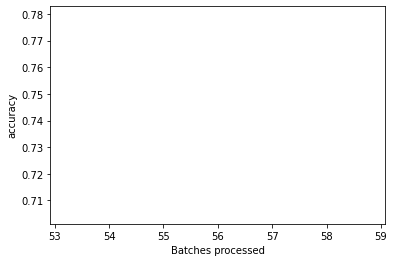

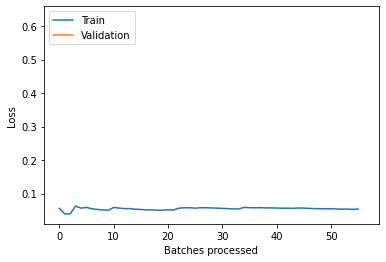

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 17 - resnet18 L50 extreme and two in middle 1000 systems 30 epochs')

##Final Tests

###L20 final tests

####TEST 18 - Resnet18 L20 system size 4000 extreme

folder for prep_data:  raw_data_transfering_4000_
Found pre-loaded data raw_data_20/raw_data_transfering_4000_training_seed1111



----
   Taking only the extreme classes
len labels:      2
len training:    2
len validation:  2
len testing:     2
labels =         ['18.0', '15.0']
----





---------
   Length of training set:  2
   Length of validation set:  2
   Length of testing set:  2
---------


Saving the model as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/20’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/20/2’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111’: File exists
Model len:  2
Layer:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  1.5208392203513577


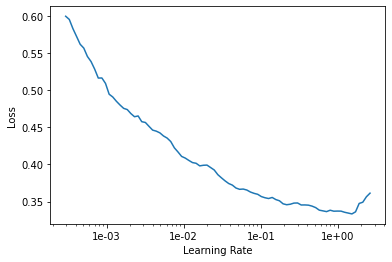

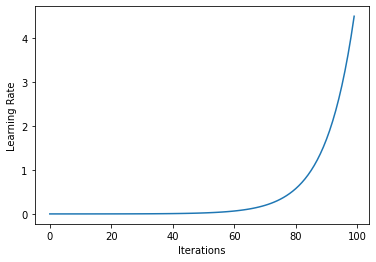

In [ ]:
#TEST 18 - resnet18 L20 extreme 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=True, batch_size=150, model=models.resnet18, model_str='resnet18')

Number of batches =  39
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-0
Best training so far:  0
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.646677,0.872842,0.494218,01:49


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.8724996, tensor(0.4985)]


Result of validate (valid):  [0.87284154, tensor(0.4942)]


train_acc =  0.501196563243866


valid_acc =  0.4942179024219513
losses:  [0.6466770768165588]
validation_losses:  [0.87284154]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=1.5208392203513577-mom=0
Best training so far:  1
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.557254,0.937987,0.495435,01:49


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.92148685, tensor(0.5014)]


Result of validate (valid):  [0.9379874, tensor(0.4954)]


train_acc =  0.5015384554862976


valid_acc =  0.4954351782798767
losses:  [0.6466770768165588, 0.557254433631897]
validation_losses:  [0.87284154, 0.9379874]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=1.5208392203513577-mom=0
Best training so far:  2
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.481685,0.477768,0.763238,01:49


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.4101459, tensor(0.8113)]


Result of validate (valid):  [0.47776842, tensor(0.7632)]


train_acc =  0.810769259929657


valid_acc =  0.7632379531860352
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538]
validation_losses:  [0.87284154, 0.9379874, 0.47776842]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=1.5208392203513577-mom=0
Best training so far:  3
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.430059,0.436039,0.790018,01:54


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.33696827, tensor(0.8651)]


Result of validate (valid):  [0.43603927, tensor(0.7900)]


train_acc =  0.8647863268852234


valid_acc =  0.7900182604789734
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=1.5208392203513577-mom=0
Best training so far:  4
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.384563,0.417656,0.800974,01:52


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.29658803, tensor(0.8868)]


Result of validate (valid):  [0.41765565, tensor(0.8010)]


train_acc =  0.8868376016616821


valid_acc =  0.8009738326072693
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=1.5208392203513577-mom=0
Best training so far:  5
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.361757,0.397490,0.813755,01:53


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.25732487, tensor(0.9096)]


Result of validate (valid):  [0.39749005, tensor(0.8138)]


train_acc =  0.90974360704422


valid_acc =  0.8137553334236145
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=1.5208392203513577-mom=0
Best training so far:  6
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.314176,0.378460,0.822276,01:52


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.22314624, tensor(0.9272)]


Result of validate (valid):  [0.37845957, tensor(0.8223)]


train_acc =  0.9271795153617859


valid_acc =  0.8222762942314148
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=1.5208392203513577-mom=0
Best training so far:  7
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.282286,0.363675,0.836275,01:54


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.19399793, tensor(0.9400)]


Result of validate (valid):  [0.3636747, tensor(0.8363)]


train_acc =  0.9408547282218933


valid_acc =  0.8362751007080078
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=1.5208392203513577-mom=0
Best training so far:  8
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.245980,0.352174,0.847231,01:55


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.16608459, tensor(0.9526)]


Result of validate (valid):  [0.35217422, tensor(0.8472)]


train_acc =  0.9526495933532715


valid_acc =  0.8472306728363037
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=1.5208392203513577-mom=0
Best training so far:  9
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.220493,0.339648,0.847231,01:53


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.14124133, tensor(0.9636)]


Result of validate (valid):  [0.33964798, tensor(0.8472)]


train_acc =  0.964102566242218


valid_acc =  0.8472306728363037
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=1.5208392203513577-mom=0
Best training so far:  10
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.192420,0.330650,0.860012,02:03


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.11650351, tensor(0.9730)]


Result of validate (valid):  [0.33065048, tensor(0.8600)]


train_acc =  0.9729914665222168


valid_acc =  0.8600121736526489
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=1.5208392203513577-mom=0
Best training so far:  11
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.166970,0.323832,0.861229,01:56


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.09784426, tensor(0.9803)]


Result of validate (valid):  [0.3238322, tensor(0.8612)]


train_acc =  0.980512797832489


valid_acc =  0.8612294793128967
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=1.5208392203513577-mom=0
Best training so far:  12
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.146789,0.318137,0.866707,01:55


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.078679055, tensor(0.9858)]


Result of validate (valid):  [0.31813663, tensor(0.8667)]


train_acc =  0.9856410026550293


valid_acc =  0.8667072653770447
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=1.5208392203513577-mom=0
Best training so far:  13
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.120903,0.313855,0.873402,01:54


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-14-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-14-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.063029416, tensor(0.9928)]


Result of validate (valid):  [0.31385532, tensor(0.8734)]


train_acc =  0.992478609085083


valid_acc =  0.8734022974967957
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-14-max_lr=1.5208392203513577-mom=0
Best training so far:  14
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.099000,0.312716,0.875837,01:54


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-15-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-15-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.04851705, tensor(0.9961)]


Result of validate (valid):  [0.31271553, tensor(0.8758)]


train_acc =  0.9958974123001099


valid_acc =  0.8758369088172913
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-15-max_lr=1.5208392203513577-mom=0
Best training so far:  15
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.081892,0.313987,0.877054,01:55


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-16-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-16-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.03791244, tensor(0.9973)]


Result of validate (valid):  [0.3139872, tensor(0.8771)]


train_acc =  0.9972649812698364


valid_acc =  0.8770541548728943
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-16-max_lr=1.5208392203513577-mom=0
Best training so far:  16
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.065981,0.317374,0.877054,01:55


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-17-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-17-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.027957326, tensor(0.9986)]


Result of validate (valid):  [0.3173741, tensor(0.8771)]


train_acc =  0.9986324906349182


valid_acc =  0.8770541548728943
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-17-max_lr=1.5208392203513577-mom=0
Best training so far:  17
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.054874,0.326579,0.877054,01:50


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-18-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-18-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.020662487, tensor(1.)]


Result of validate (valid):  [0.32657897, tensor(0.8771)]


train_acc =  1.0


valid_acc =  0.8770541548728943
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-18-max_lr=1.5208392203513577-mom=0
Best training so far:  18
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.040235,0.329405,0.879489,01:53


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-19-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-19-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.014906662, tensor(1.)]


Result of validate (valid):  [0.3294055, tensor(0.8795)]


train_acc =  1.0


valid_acc =  0.8794887661933899
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-19-max_lr=1.5208392203513577-mom=0
Best training so far:  19
Using (max) lr of:  1.5208392203513577
lr being used:  slice(1e-06, 0.0001,

epoch,train_loss,valid_loss,accuracy,time
0,0.033855,0.339765,0.882532,01:53


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-20-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-20-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0107951965, tensor(1.)]


Result of validate (valid):  [0.3397646, tensor(0.8825)]


train_acc =  1.0


valid_acc =  0.8825319409370422
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-20-max_lr=1.5208392203513577-mom=0
Best training so far:  20
Using (max) lr of:  1.5208392203513577
lr b

epoch,train_loss,valid_loss,accuracy,time
0,0.023678,0.341423,0.878271,01:59


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-21-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-21-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.007915422, tensor(1.)]


Result of validate (valid):  [0.34142262, tensor(0.8783)]


train_acc =  1.0


valid_acc =  0.8782714605331421
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-21-max_lr=1.5208392203513577-mom=0
Best training so far:  21
Using (ma

epoch,train_loss,valid_loss,accuracy,time
0,0.022781,0.354729,0.876446,01:51


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-22-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-22-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.005994437, tensor(1.)]


Result of validate (valid):  [0.35472894, tensor(0.8764)]


train_acc =  1.0


valid_acc =  0.8764455318450928
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-22-max_lr=1.5208392203513577-mom=0
Be

epoch,train_loss,valid_loss,accuracy,time
0,0.015284,0.371059,0.874011,01:51


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-23-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-23-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0047781393, tensor(1.)]


Result of validate (valid):  [0.37105858, tensor(0.8740)]


train_acc =  1.0


valid_acc =  0.8740109801292419
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-23-m

epoch,train_loss,valid_loss,accuracy,time
0,0.012980,0.371519,0.880097,01:54


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-24-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-24-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.00335642, tensor(1.)]


Result of validate (valid):  [0.3715193, tensor(0.8801)]


train_acc =  1.0


valid_acc =  0.8800973892211914
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transferi

epoch,train_loss,valid_loss,accuracy,time
0,0.009394,0.382907,0.880706,02:02


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-25-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-25-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0025717956, tensor(1.)]


Result of validate (valid):  [0.38290742, tensor(0.8807)]


train_acc =  1.0


valid_acc =  0.8807060122489929
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADA

epoch,train_loss,valid_loss,accuracy,time
0,0.007137,0.391421,0.881315,02:03


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-26-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-26-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0019402019, tensor(1.)]


Result of validate (valid):  [0.391421, tensor(0.8813)]


train_acc =  1.0


valid_acc =  0.8813146948814392
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352, 0.007136923260986805]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742, 0.391421]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_ra

epoch,train_loss,valid_loss,accuracy,time
0,0.005686,0.402523,0.880097,02:01


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-27-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-27-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0015068555, tensor(1.)]


Result of validate (valid):  [0.40252328, tensor(0.8801)]


train_acc =  1.0


valid_acc =  0.8800973892211914
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352, 0.007136923260986805, 0.005686075426638126]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742, 0.391421, 0.40252328]
loading epoch  /content/drive/MyDrive/ModelStages/20/2/classes

epoch,train_loss,valid_loss,accuracy,time
0,0.004090,0.410261,0.883749,02:00


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-28-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-28-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.001127853, tensor(1.)]


Result of validate (valid):  [0.41026127, tensor(0.8837)]


train_acc =  1.0


valid_acc =  0.88374924659729
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352, 0.007136923260986805, 0.005686075426638126, 0.004090120550245047]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742, 0.391421, 0.40252328, 0.41026127]
loading epoch  /content/drive/

epoch,train_loss,valid_loss,accuracy,time
0,0.003624,0.422266,0.874011,02:03


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-29-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-29-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0009204108, tensor(1.)]


Result of validate (valid):  [0.42226622, tensor(0.8740)]


train_acc =  1.0


valid_acc =  0.8740109801292419
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352, 0.007136923260986805, 0.005686075426638126, 0.004090120550245047, 0.0036239461041986942]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742, 0.391421, 0.40252328, 0.41026127, 0.422

epoch,train_loss,valid_loss,accuracy,time
0,0.002948,0.420116,0.881315,02:07


/content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-30-max_lr=1.5208392203513577-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_training_1111/epochs-30-max_lr=1.5208392203513577-mom=0


Result of validate (train):  [0.0007304752, tensor(1.)]


Result of validate (valid):  [0.42011556, tensor(0.8813)]


train_acc =  1.0


valid_acc =  0.8813146948814392
losses:  [0.6466770768165588, 0.557254433631897, 0.4816851317882538, 0.4300587773323059, 0.38456347584724426, 0.3617570102214813, 0.31417641043663025, 0.2822856605052948, 0.24597953259944916, 0.2204933911561966, 0.1924203336238861, 0.16697022318840027, 0.14678850769996643, 0.12090321630239487, 0.098999984562397, 0.08189192414283752, 0.06598120182752609, 0.05487387627363205, 0.04023515060544014, 0.03385481610894203, 0.023677514865994453, 0.02278103306889534, 0.01528383418917656, 0.012980482541024685, 0.009393839165568352, 0.007136923260986805, 0.005686075426638126, 0.004090120550245047, 0.0036239461041986942, 0.002947605447843671]
validation_losses:  [0.87284154, 0.9379874, 0.47776842, 0.43603927, 0.41765565, 0.39749005, 0.37845957, 0.3636747, 0.35217422, 0.33964798, 0.33065048, 0.3238322, 0.31813663, 0.31385532, 0.31271553, 0.3139872, 0.3173741, 0.32657897, 0.3294055, 0.3397646, 0.34142262, 0.35472894, 0.37105858, 0.3715193, 0.38290742, 0.391421, 0.40252

([0.6466770768165588,
  0.557254433631897,
  0.4816851317882538,
  0.4300587773323059,
  0.38456347584724426,
  0.3617570102214813,
  0.31417641043663025,
  0.2822856605052948,
  0.24597953259944916,
  0.2204933911561966,
  0.1924203336238861,
  0.16697022318840027,
  0.14678850769996643,
  0.12090321630239487,
  0.098999984562397,
  0.08189192414283752,
  0.06598120182752609,
  0.05487387627363205,
  0.04023515060544014,
  0.03385481610894203,
  0.023677514865994453,
  0.02278103306889534,
  0.01528383418917656,
  0.012980482541024685,
  0.009393839165568352,
  0.007136923260986805,
  0.005686075426638126,
  0.004090120550245047,
  0.0036239461041986942,
  0.002947605447843671],
 [0.87284154,
  0.9379874,
  0.47776842,
  0.43603927,
  0.41765565,
  0.39749005,
  0.37845957,
  0.3636747,
  0.35217422,
  0.33964798,
  0.33065048,
  0.3238322,
  0.31813663,
  0.31385532,
  0.31271553,
  0.3139872,
  0.3173741,
  0.32657897,
  0.3294055,
  0.3397646,
  0.34142262,
  0.35472894,
  0.371058

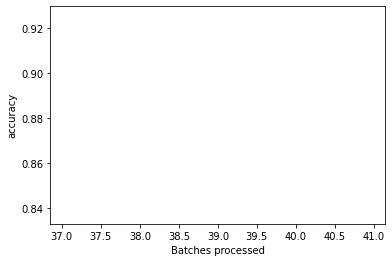

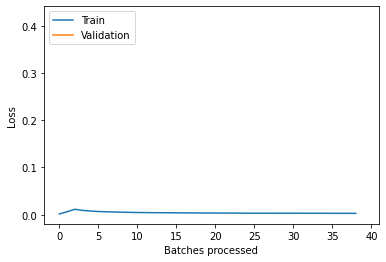

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=True, csv_name='TEST 18 - resnet18 L20 extreme 4000 systems 30 epochs')

####TEST 19 - Resnet18 L20 system size 4000 extreme and one in the middle

folder for prep_data:  raw_data_transfering_4000_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/
Number of classes:  3
Included:  W18.0-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/W18.0-4000data_seed1111.csv
Skipped:  W17.75-4000data_seed1111.csv
Skipped:  W17.5-4000data_seed1111.csv
Skipped:  W17.25-4000data_seed1111.csv
Skipped:  W17.0-4000data_seed1111.csv
Skipped:  W16.8-4000data_seed1111.csv
Skipped:  W16.7-4000data_seed1111.csv
Skipped:  W16.6-4000data_seed1111.csv
Skipped:  W16.5-4000data_seed1111.csv
Included:  W16.4-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/W16.4-4000data_seed1111.csv
Skipped:  W16.3-4000data_seed1111.csv
Skipped:  W16.2-4000data_seed1111.csv
Skipped:  W16.0-4000data_seed1111.csv
Skipped:  W15.75-4000data_seed1111.csv
Skipp

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.6399789706012268


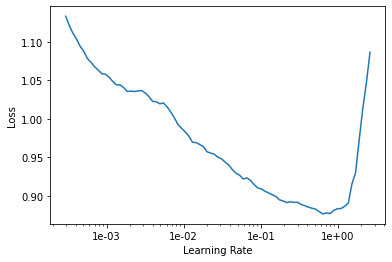

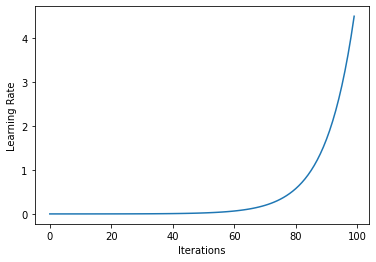

In [ ]:
#TEST 19 - resnet18 L20 extreme and one in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=225, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9])

Number of batches =  39
no load - epoch chunk =  1
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.183985,1.206709,0.328845,02:28


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [1.1981337, tensor(0.3385)]


Result of validate (valid):  [1.2067091, tensor(0.3288)]


train_acc =  0.33937323093414307


valid_acc =  0.32884538173675537
losses:  [1.1839845180511475]
validation_losses:  [1.2067091]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.081953,1.422397,0.328845,02:26


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [1.4062706, tensor(0.3397)]


Result of validate (valid):  [1.422397, tensor(0.3288)]


train_acc =  0.339145302772522


valid_acc =  0.32884538173675537
losses:  [1.1839845180511475, 1.0819530487060547]
validation_losses:  [1.2067091, 1.422397]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.017986,0.970989,0.516116,02:25


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.8895999, tensor(0.5777)]


Result of validate (valid):  [0.9709887, tensor(0.5161)]


train_acc =  0.5775498747825623


valid_acc =  0.5161158442497253
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114]
validation_losses:  [1.2067091, 1.422397, 0.9709887]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.964371,0.930086,0.552836,02:30


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.81689996, tensor(0.6392)]


Result of validate (valid):  [0.9300863, tensor(0.5528)]


train_acc =  0.6388604044914246


valid_acc =  0.5528355836868286
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.924412,0.909664,0.573235,02:27


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.774119, tensor(0.6692)]


Result of validate (valid):  [0.9096641, tensor(0.5732)]


train_acc =  0.668945848941803


valid_acc =  0.5732353925704956
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.884371,0.890722,0.587515,02:29


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.73345065, tensor(0.6944)]


Result of validate (valid):  [0.89072233, tensor(0.5875)]


train_acc =  0.6944729089736938


valid_acc =  0.5875152945518494
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.841639,0.872926,0.607099,02:28


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.6916148, tensor(0.7244)]


Result of validate (valid):  [0.87292576, tensor(0.6071)]


train_acc =  0.7238746285438538


valid_acc =  0.6070991158485413
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.810014,0.854340,0.610771,02:31


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.6530164, tensor(0.7505)]


Result of validate (valid):  [0.8543399, tensor(0.6108)]


train_acc =  0.7506552934646606


valid_acc =  0.610771119594574
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.760476,0.837284,0.618523,02:32


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.6148371, tensor(0.7737)]


Result of validate (valid):  [0.8372836, tensor(0.6185)]


train_acc =  0.7728775143623352


valid_acc =  0.6185230612754822
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.723249,0.820740,0.638515,02:27


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.57768565, tensor(0.7977)]


Result of validate (valid):  [0.82074016, tensor(0.6385)]


train_acc =  0.7973788976669312


valid_acc =  0.6385148763656616
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.695368,0.802824,0.646675,02:30


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.54008895, tensor(0.8210)]


Result of validate (valid):  [0.8028237, tensor(0.6467)]


train_acc =  0.8217663764953613


valid_acc =  0.6466748118400574
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.663370,0.790707,0.647899,02:31


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.505457, tensor(0.8369)]


Result of validate (valid):  [0.79070723, tensor(0.6479)]


train_acc =  0.8368090987205505


valid_acc =  0.64789879322052
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.615584,0.776434,0.660547,02:31


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.47019118, tensor(0.8571)]


Result of validate (valid):  [0.7764344, tensor(0.6605)]


train_acc =  0.8566381931304932


valid_acc =  0.6605467200279236
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.587833,0.766117,0.668299,02:32


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-14-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-14-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.43881917, tensor(0.8754)]


Result of validate (valid):  [0.7661169, tensor(0.6683)]


train_acc =  0.8760113716125488


valid_acc =  0.6682986617088318
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.561481,0.752418,0.676459,02:33


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-15-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-15-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.40512824, tensor(0.8908)]


Result of validate (valid):  [0.75241816, tensor(0.6765)]


train_acc =  0.8912820219993591


valid_acc =  0.6764585971832275
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.514629,0.743003,0.694002,02:33


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-16-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-16-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.3727682, tensor(0.9043)]


Result of validate (valid):  [0.7430028, tensor(0.6940)]


train_acc =  0.9034757614135742


valid_acc =  0.6940024495124817
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.481840,0.731330,0.698082,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-17-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-17-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.34167314, tensor(0.9178)]


Result of validate (valid):  [0.73133004, tensor(0.6981)]


train_acc =  0.9173789024353027


valid_acc =  0.6980823874473572
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.451370,0.722184,0.706242,02:35


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-18-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-18-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.31119394, tensor(0.9332)]


Result of validate (valid):  [0.7221844, tensor(0.7062)]


train_acc =  0.9334473013877869


valid_acc =  0.7062423229217529
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.430595,0.714217,0.711546,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-19-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-19-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.2844461, tensor(0.9421)]


Result of validate (valid):  [0.714217, tensor(0.7115)]


train_acc =  0.9426780343055725


valid_acc =  0.7115463018417358
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.393400,0.703646,0.720930,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-20-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-20-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.25563046, tensor(0.9534)]


Result of validate (valid):  [0.7036455, tensor(0.7209)]


train_acc =  0.9531623721122742


valid_acc =  0.7209302186965942
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.363664,0.696847,0.725826,02:35


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-21-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-21-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.2287261, tensor(0.9624)]


Result of validate (valid):  [0.6968472, tensor(0.7258)]


train_acc =  0.9618233442306519


valid_acc =  0.7258262038230896
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.328344,0.689112,0.731130,02:37


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-22-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-22-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.20753394, tensor(0.9696)]


Result of validate (valid):  [0.6891123, tensor(0.7311)]


train_acc =  0.9693447351455688


valid_acc =  0.7311301231384277
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.307219,0.681362,0.738882,02:33


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-23-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-23-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.18564267, tensor(0.9763)]


Result of validate (valid):  [0.6813617, tensor(0.7389)]


train_acc =  0.9766381978988647


valid_acc =  0.7388820648193359
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.277402,0.679389,0.739698,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-24-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-24-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.16613193, tensor(0.9807)]


Result of validate (valid):  [0.6793893, tensor(0.7397)]


train_acc =  0.9808546900749207


valid_acc =  0.7396981120109558
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.248391,0.676860,0.742554,02:33


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-25-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-25-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.14757054, tensor(0.9862)]


Result of validate (valid):  [0.6768604, tensor(0.7426)]


train_acc =  0.9864387512207031


valid_acc =  0.7425540685653687
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.236301,0.675507,0.744594,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-26-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-26-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.13066922, tensor(0.9887)]


Result of validate (valid):  [0.6755072, tensor(0.7446)]


train_acc =  0.9887179732322693


valid_acc =  0.7445940375328064
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698, 0.23630136251449585]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604, 0.6755072]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.210536,0.678511,0.740922,02:30


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-27-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-27-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.11628334, tensor(0.9929)]


Result of validate (valid):  [0.67851096, tensor(0.7409)]


train_acc =  0.9928205013275146


valid_acc =  0.7409220933914185
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698, 0.23630136251449585, 0.21053598821163177]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604, 0.6755072, 0.67851096]
Using (max) lr of:  0.6399789706012268
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.190091,0.677949,0.747858,02:30


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-28-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-28-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.10282172, tensor(0.9952)]


Result of validate (valid):  [0.6779495, tensor(0.7479)]


train_acc =  0.9949857592582703


valid_acc =  0.7478579878807068
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698, 0.23630136251449585, 0.21053598821163177, 0.1900913268327713]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604, 0.6755072, 0.67851096, 0.6779495]
Using (max) lr of:  0.6399789706012268
lr being used:  slic

epoch,train_loss,valid_loss,accuracy,time
0,0.176730,0.683190,0.742962,02:30


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-29-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-29-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.0910161, tensor(0.9960)]


Result of validate (valid):  [0.6831901, tensor(0.7430)]


train_acc =  0.9958974123001099


valid_acc =  0.7429620623588562
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698, 0.23630136251449585, 0.21053598821163177, 0.1900913268327713, 0.1767304241657257]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604, 0.6755072, 0.67851096, 0.6779495, 0.6831901]
Using (max) lr of:  0.639978

epoch,train_loss,valid_loss,accuracy,time
0,0.156114,0.688757,0.742962,02:34


/content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-30-max_lr=0.6399789706012268-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_training_1111/epochs-30-max_lr=0.6399789706012268-mom=0


Result of validate (train):  [0.08040576, tensor(0.9972)]


Result of validate (valid):  [0.6887573, tensor(0.7430)]


train_acc =  0.9971510171890259


valid_acc =  0.7429620623588562
losses:  [1.1839845180511475, 1.0819530487060547, 1.0179864168167114, 0.9643709659576416, 0.9244115948677063, 0.8843714594841003, 0.8416388034820557, 0.8100137114524841, 0.7604764699935913, 0.7232487201690674, 0.6953680515289307, 0.6633696556091309, 0.6155838370323181, 0.5878332257270813, 0.5614811778068542, 0.514629065990448, 0.4818398356437683, 0.45137009024620056, 0.4305947721004486, 0.39339953660964966, 0.3636644780635834, 0.3283444344997406, 0.30721908807754517, 0.2774019241333008, 0.24839133024215698, 0.23630136251449585, 0.21053598821163177, 0.1900913268327713, 0.1767304241657257, 0.1561136543750763]
validation_losses:  [1.2067091, 1.422397, 0.9709887, 0.9300863, 0.9096641, 0.89072233, 0.87292576, 0.8543399, 0.8372836, 0.82074016, 0.8028237, 0.79070723, 0.7764344, 0.7661169, 0.75241816, 0.7430028, 0.73133004, 0.7221844, 0.714217, 0.7036455, 0.6968472, 0.6891123, 0.6813617, 0.6793893, 0.6768604, 0.6755072, 0.67851096, 0.6779495, 0.6831901, 0.688757

([1.1839845180511475,
  1.0819530487060547,
  1.0179864168167114,
  0.9643709659576416,
  0.9244115948677063,
  0.8843714594841003,
  0.8416388034820557,
  0.8100137114524841,
  0.7604764699935913,
  0.7232487201690674,
  0.6953680515289307,
  0.6633696556091309,
  0.6155838370323181,
  0.5878332257270813,
  0.5614811778068542,
  0.514629065990448,
  0.4818398356437683,
  0.45137009024620056,
  0.4305947721004486,
  0.39339953660964966,
  0.3636644780635834,
  0.3283444344997406,
  0.30721908807754517,
  0.2774019241333008,
  0.24839133024215698,
  0.23630136251449585,
  0.21053598821163177,
  0.1900913268327713,
  0.1767304241657257,
  0.1561136543750763],
 [1.2067091,
  1.422397,
  0.9709887,
  0.9300863,
  0.9096641,
  0.89072233,
  0.87292576,
  0.8543399,
  0.8372836,
  0.82074016,
  0.8028237,
  0.79070723,
  0.7764344,
  0.7661169,
  0.75241816,
  0.7430028,
  0.73133004,
  0.7221844,
  0.714217,
  0.7036455,
  0.6968472,
  0.6891123,
  0.6813617,
  0.6793893,
  0.6768604,
  0.6

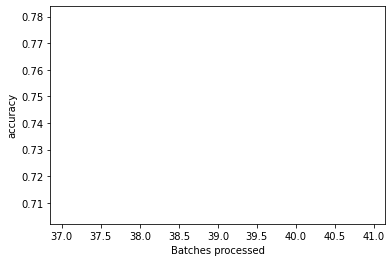

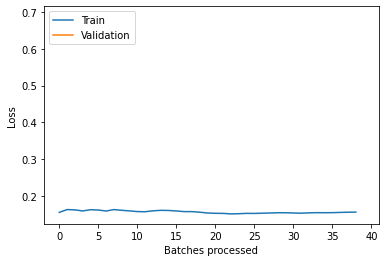

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 19 - resnet18 L20 extreme and one in the middle 4000 systems 30 epochs')

####TEST 20 - Resnet18 L20 system size 4000 extreme and two in the middle

folder for prep_data:  raw_data_transfering_4000_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/
Number of classes:  4
Included:  W18.0-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/W18.0-4000data_seed1111.csv
Skipped:  W17.75-4000data_seed1111.csv
Skipped:  W17.5-4000data_seed1111.csv
Skipped:  W17.25-4000data_seed1111.csv
Skipped:  W17.0-4000data_seed1111.csv
Skipped:  W16.8-4000data_seed1111.csv
Included:  W16.7-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_transfering_4000_training_seed1111/W16.7-4000data_seed1111.csv
Skipped:  W16.6-4000data_seed1111.csv
Skipped:  W16.5-4000data_seed1111.csv
Skipped:  W16.4-4000data_seed1111.csv
Skipped:  W16.3-4000data_seed1111.csv
Included:  W16.2-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_20/raw_data_trans

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.7131081559054943


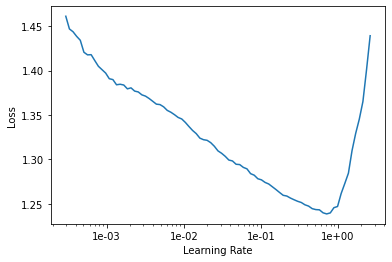

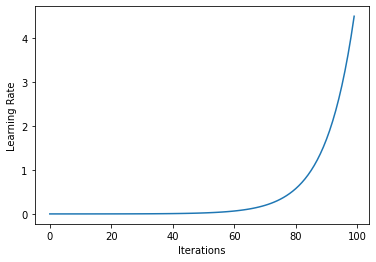

In [ ]:
#TEST 20 - resnet18 L20 extreme and two in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, batch_size=300, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 20 - resnet18 L20 extreme and two in the middle 4000 systems 30 epochs')

Number of batches =  40
no load - epoch chunk =  1
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.510954,1.683889,0.248969,03:51


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-1-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.6921719, tensor(0.2494)]


Result of validate (valid):  [1.6838889, tensor(0.2490)]


train_acc =  0.24975000321865082


valid_acc =  0.24896924197673798
losses:  [1.5109541416168213]
validation_losses:  [1.6838889]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.428738,1.671146,0.250238,03:34


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-2-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.6651691, tensor(0.2504)]


Result of validate (valid):  [1.6711456, tensor(0.2502)]


train_acc =  0.24958333373069763


valid_acc =  0.2502378821372986
losses:  [1.5109541416168213, 1.4287375211715698]
validation_losses:  [1.6838889, 1.6711456]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.366043,1.289341,0.399937,03:25


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-3-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.1981729, tensor(0.4673)]


Result of validate (valid):  [1.2893413, tensor(0.3999)]


train_acc =  0.4674166738986969


valid_acc =  0.3999365568161011
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438]
validation_losses:  [1.6838889, 1.6711456, 1.2893413]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.317200,1.254507,0.418332,03:23


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-4-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.1307735, tensor(0.5185)]


Result of validate (valid):  [1.2545071, tensor(0.4183)]


train_acc =  0.518666684627533


valid_acc =  0.41833174228668213
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.271245,1.230124,0.439899,03:23


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-5-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.0817858, tensor(0.5632)]


Result of validate (valid):  [1.2301242, tensor(0.4399)]


train_acc =  0.5632500052452087


valid_acc =  0.4398985207080841
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.225719,1.210786,0.450999,03:22


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-6-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [1.0381304, tensor(0.5912)]


Result of validate (valid):  [1.2107859, tensor(0.4510)]


train_acc =  0.5911666750907898


valid_acc =  0.45099905133247375
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.185295,1.189592,0.475737,03:28


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-7-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.99398386, tensor(0.6247)]


Result of validate (valid):  [1.1895915, tensor(0.4757)]


train_acc =  0.624750018119812


valid_acc =  0.47573739290237427
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.147350,1.173191,0.484935,03:21


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-8-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.9540166, tensor(0.6493)]


Result of validate (valid):  [1.1731913, tensor(0.4849)]


train_acc =  0.6498333215713501


valid_acc =  0.4849349856376648
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.109529,1.154694,0.494133,03:21


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-9-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.9139498, tensor(0.6781)]


Result of validate (valid):  [1.1546938, tensor(0.4941)]


train_acc =  0.6774166822433472


valid_acc =  0.4941325783729553
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282, 1.109528660774231]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913, 1.1546938]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.064239,1.138245,0.509039,03:23


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-10-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.8716661, tensor(0.7023)]


Result of validate (valid):  [1.138245, tensor(0.5090)]


train_acc =  0.7019166946411133


valid_acc =  0.5090389847755432
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282, 1.109528660774231, 1.0642391443252563]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913, 1.1546938, 1.138245]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.022949,1.122308,0.513162,03:22


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-11-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.8310132, tensor(0.7270)]


Result of validate (valid):  [1.1223081, tensor(0.5132)]


train_acc =  0.7269166707992554


valid_acc =  0.5131620764732361
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282, 1.109528660774231, 1.0642391443252563, 1.0229487419128418]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913, 1.1546938, 1.138245, 1.1223081]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.989082,1.105037,0.530289,03:23


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-12-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.7902202, tensor(0.7533)]


Result of validate (valid):  [1.1050372, tensor(0.5303)]


train_acc =  0.7538333535194397


valid_acc =  0.5302886366844177
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282, 1.109528660774231, 1.0642391443252563, 1.0229487419128418, 0.9890819191932678]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913, 1.1546938, 1.138245, 1.1223081, 1.1050372]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.946886,1.088368,0.540121,03:22


/content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/20/4/classes=4-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=300-ntrain=raw_data_transfering_4000_training_1111/epochs-13-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.7492921, tensor(0.7788)]


Result of validate (valid):  [1.088368, tensor(0.5401)]


train_acc =  0.7787500023841858


valid_acc =  0.540120542049408
losses:  [1.5109541416168213, 1.4287375211715698, 1.3660427331924438, 1.3172000646591187, 1.2712446451187134, 1.2257189750671387, 1.1852949857711792, 1.1473499536514282, 1.109528660774231, 1.0642391443252563, 1.0229487419128418, 0.9890819191932678, 0.9468860030174255]
validation_losses:  [1.6838889, 1.6711456, 1.2893413, 1.2545071, 1.2301242, 1.2107859, 1.1895915, 1.1731913, 1.1546938, 1.138245, 1.1223081, 1.1050372, 1.088368]
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time


####TEST 23.5 - Resnet18 L20 system size 4000 ALL classes

In [ ]:
#TEST 23.5 - resnet18 L20 ALL Classes 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 20

create_learner(folder, d_type, seed, sys_size, batch_size=1275, model=models.resnet18, model_str='resnet18')

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 23.5 - resnet18 L20 ALL classes 4000 systems 30 epochs')

###L30 final tests

####TEST 21 - Resnet18 L30 system size 4000 extreme

folder for prep_data:  raw_data_transfering_4000_30_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
len files:  16
Included:  W18.0-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
len files:  16
Skipped:  W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
len files:  16
Skipped:  W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
len files:  16
Skipped:  W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
len files:  16
Skipped:  W17.0-4000data_seed1111.csv
W16.8-4000data_seed1111.csv
len files:  16
Skipped:  W16.8-4000data_seed1111.csv
W16.7-4000data_seed1111.csv
len files:  16
Skipped:  W16.7-4000data_seed1111.csv
W16.6-4000data_seed1111.csv
len files:  16
Skipped:  W16.6-4000data_seed1111.csv
W16.5-4000data_see

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.0309352836369049


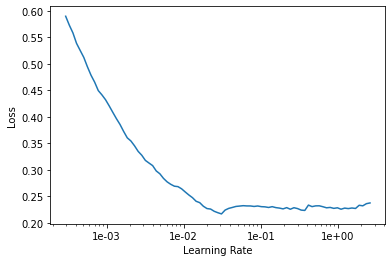

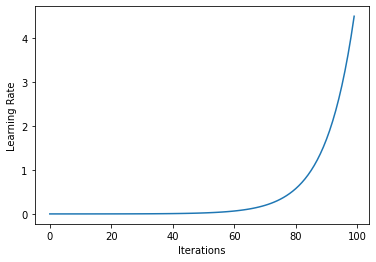

In [ ]:
#TEST 21 - resnet18 L30 extreme 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=True, batch_size=150, model=models.resnet18, model_str='resnet18')  #BS is 1/40th of the total samples

Number of batches =  40
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-18-max_lr=0.0309352836369049-mom=0
Best training so far:  18
Using (max) lr of:  0.0309352836369049
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.048014,0.065018,0.981970,02:34


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-19-max_lr=0.0309352836369049-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-19-max_lr=0.0309352836369049-mom=0


Result of validate (train):  [0.021953901, tensor(0.9977)]


Result of validate (valid):  [0.065018095, tensor(0.9820)]


train_acc =  0.9976666569709778


valid_acc =  0.9819703698158264
losses:  [0.04801355302333832]
validation_losses:  [0.065018095]
loading epoch  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-19-max_lr=0.0309352836369049-mom=0
Best training so far:  19
Using (max) lr of:  0.0309352836369049
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.038908,0.062817,0.979395,02:35


/content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-20-max_lr=0.0309352836369049-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/2/classes=2-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=150-ntrain=raw_data_transfering_4000_30_training_1111/epochs-20-max_lr=0.0309352836369049-mom=0


Result of validate (train):  [0.014836482, tensor(0.9988)]


Result of validate (valid):  [0.06281702, tensor(0.9794)]


train_acc =  0.9988333582878113


valid_acc =  0.9793947339057922
losses:  [0.04801355302333832, 0.0389079824090004]
validation_losses:  [0.065018095, 0.06281702]


([0.04801355302333832, 0.0389079824090004],
 [0.065018095, 0.06281702],
 <function fastai.metrics.accuracy>)

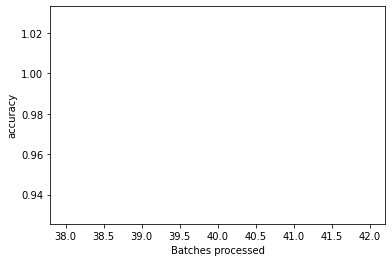

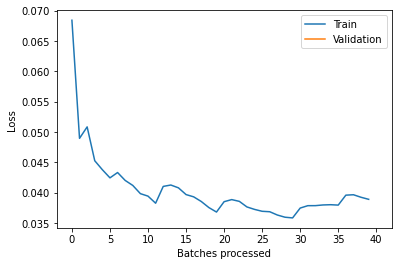

In [ ]:
train_max_epochs(20, lr='BEST', epoch_chunk=1, load=True, csv_name='TEST 21 - resnet18 L30 extreme 4000 systems 30 epochs')

####TEST 22 - Resnet18 L30 system size 4000 extreme and one in the middle

folder for prep_data:  raw_data_transfering_4000_30_
Found pre-loaded data raw_data_30/raw_data_transfering_4000_30_training_seed1111


---------
   Length of training set:  2
   Length of validation set:  2
   Length of testing set:  2
---------


Saving the model as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/30’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/30/3’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111’: File exists
Model len:  2
Layer:      Sequential(
  (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.7131081559054943


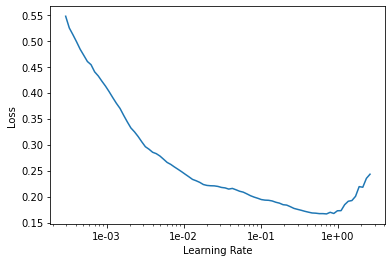

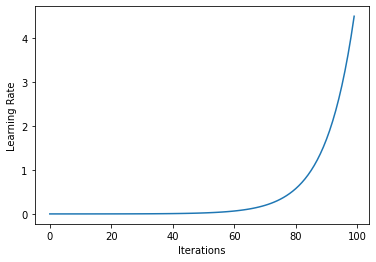

In [ ]:
#TEST 22 - resnet18 L30 extreme and one in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, save=True, show_model=False, extr=False, batch_size=225, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9]) #BS is 1/40th of the total samples

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=True, csv_name='TEST 22 - resnet18 L30 extreme and one in the middle 4000 systems 30 epochs', folder=folder)

Number of batches =  26
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-0
Best training so far:  0
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.679402,0.739251,0.511912,02:26


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-1-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-1-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.74968874, tensor(0.4949)]


Result of validate (valid):  [0.73925066, tensor(0.5119)]


train_acc =  0.4941880404949188


valid_acc =  0.5119124054908752
losses:  [0.679401695728302]
validation_losses:  [0.73925066]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-1-max_lr=0.7131081559054943-mom=0
Best training so far:  1
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.544020,0.708837,0.462331,02:26


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-2-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-2-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.7039105, tensor(0.4860)]


Result of validate (valid):  [0.70883715, tensor(0.4623)]


train_acc =  0.4871794879436493


valid_acc =  0.46233096718788147
losses:  [0.679401695728302, 0.5440197587013245]
validation_losses:  [0.73925066, 0.70883715]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-2-max_lr=0.7131081559054943-mom=0
Best training so far:  2
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.465982,0.783070,0.475853,02:25


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-3-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-3-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.7795037, tensor(0.4819)]


Result of validate (valid):  [0.78307015, tensor(0.4759)]


train_acc =  0.48444443941116333


valid_acc =  0.47585317492485046
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653]
validation_losses:  [0.73925066, 0.70883715, 0.78307015]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-3-max_lr=0.7131081559054943-mom=0
Best training so far:  3
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.395434,0.591909,0.699936,02:26


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-4-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-4-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.5704447, tensor(0.7113)]


Result of validate (valid):  [0.5919085, tensor(0.6999)]


train_acc =  0.7097436189651489


valid_acc =  0.6999356150627136
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-4-max_lr=0.7131081559054943-mom=0
Best training so far:  4
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.345990,0.367303,0.840309,02:28


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-5-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-5-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.27463987, tensor(0.8921)]


Result of validate (valid):  [0.3673035, tensor(0.8403)]


train_acc =  0.8924786448478699


valid_acc =  0.8403090834617615
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-5-max_lr=0.7131081559054943-mom=0
Best training so far:  5
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.312892,0.334143,0.858983,02:28


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-6-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-6-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.2285273, tensor(0.9185)]


Result of validate (valid):  [0.33414266, tensor(0.8590)]


train_acc =  0.9208546876907349


valid_acc =  0.8589826226234436
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-6-max_lr=0.7131081559054943-mom=0
Best training so far:  6
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.270134,0.316683,0.865422,02:35


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-7-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-7-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.1975398, tensor(0.9342)]


Result of validate (valid):  [0.31668285, tensor(0.8654)]


train_acc =  0.9347008466720581


valid_acc =  0.8654217720031738
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-7-max_lr=0.7131081559054943-mom=0
Best training so far:  7
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.235977,0.304645,0.872505,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-8-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-8-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.16915378, tensor(0.9470)]


Result of validate (valid):  [0.30464518, tensor(0.8725)]


train_acc =  0.947692334651947


valid_acc =  0.8725048303604126
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-8-max_lr=0.7131081559054943-mom=0
Best training so far:  8
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.216099,0.288349,0.884739,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-9-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-9-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.14573377, tensor(0.9603)]


Result of validate (valid):  [0.28834867, tensor(0.8847)]


train_acc =  0.9613675475120544


valid_acc =  0.8847392201423645
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-9-max_lr=0.7131081559054943-mom=0
Best training so far:  9
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.180915,0.278784,0.894398,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-10-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-10-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.12243004, tensor(0.9696)]


Result of validate (valid):  [0.27878377, tensor(0.8944)]


train_acc =  0.9688888788223267


valid_acc =  0.8943979144096375
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-10-max_lr=0.7131081559054943-mom=0
Best training so far:  10
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.159471,0.264692,0.897618,02:30


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-11-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-11-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.10165693, tensor(0.9757)]


Result of validate (valid):  [0.26469174, tensor(0.8976)]


train_acc =  0.9757264852523804


valid_acc =  0.897617518901825
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-11-max_lr=0.7131081559054943-mom=0
Best training so far:  11
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.134957,0.252182,0.904701,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-12-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-12-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.08170305, tensor(0.9832)]


Result of validate (valid):  [0.25218195, tensor(0.9047)]


train_acc =  0.983589768409729


valid_acc =  0.9047005772590637
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-12-max_lr=0.7131081559054943-mom=0
Best training so far:  12
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.115247,0.242802,0.905344,02:28


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-13-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-13-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.06750103, tensor(0.9879)]


Result of validate (valid):  [0.24280198, tensor(0.9053)]


train_acc =  0.9885470271110535


valid_acc =  0.9053444862365723
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-13-max_lr=0.7131081559054943-mom=0
Best training so far:  13
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.097885,0.238936,0.905344,02:30


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-14-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-14-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.05277507, tensor(0.9920)]


Result of validate (valid):  [0.23893593, tensor(0.9053)]


train_acc =  0.9919658303260803


valid_acc =  0.9053444862365723
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387, 0.09788500517606735]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198, 0.23893593]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-14-max_lr=0.7131081559054943-mom=0
Best training so far:  14
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.076765,0.231371,0.910496,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-15-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-15-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.03972602, tensor(0.9968)]


Result of validate (valid):  [0.23137146, tensor(0.9105)]


train_acc =  0.9969230890274048


valid_acc =  0.9104958176612854
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387, 0.09788500517606735, 0.07676536589860916]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198, 0.23893593, 0.23137146]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-15-max_lr=0.7131081559054943-mom=0
Best training so far:  15
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.062303,0.226598,0.911140,02:40


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-16-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-16-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.030508451, tensor(0.9981)]


Result of validate (valid):  [0.22659795, tensor(0.9111)]


train_acc =  0.9982905983924866


valid_acc =  0.911139726638794
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387, 0.09788500517606735, 0.07676536589860916, 0.062302879989147186]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198, 0.23893593, 0.23137146, 0.22659795]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-16-max_lr=0.7131081559054943-mom=0
Best training so far:  16
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,0.052842,0.223735,0.913715,02:28


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-17-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-17-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.022929223, tensor(0.9988)]


Result of validate (valid):  [0.22373527, tensor(0.9137)]


train_acc =  0.998803436756134


valid_acc =  0.9137153625488281
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387, 0.09788500517606735, 0.07676536589860916, 0.062302879989147186, 0.05284244194626808]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198, 0.23893593, 0.23137146, 0.22659795, 0.22373527]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-17-max_lr=0.7131081559054943-mom=0
Best training so far:  17
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.039197,0.224765,0.914359,02:29


/content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-18-max_lr=0.7131081559054943-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-18-max_lr=0.7131081559054943-mom=0


Result of validate (train):  [0.017124884, tensor(0.9993)]


Result of validate (valid):  [0.22476467, tensor(0.9144)]


train_acc =  0.9993162155151367


valid_acc =  0.9143593311309814
losses:  [0.679401695728302, 0.5440197587013245, 0.46598178148269653, 0.39543426036834717, 0.3459903299808502, 0.31289154291152954, 0.2701340317726135, 0.23597735166549683, 0.21609865128993988, 0.1809145212173462, 0.15947052836418152, 0.13495738804340363, 0.11524727940559387, 0.09788500517606735, 0.07676536589860916, 0.062302879989147186, 0.05284244194626808, 0.0391971692442894]
validation_losses:  [0.73925066, 0.70883715, 0.78307015, 0.5919085, 0.3673035, 0.33414266, 0.31668285, 0.30464518, 0.28834867, 0.27878377, 0.26469174, 0.25218195, 0.24280198, 0.23893593, 0.23137146, 0.22659795, 0.22373527, 0.22476467]
loading epoch  /content/drive/MyDrive/ModelStages/30/3/classes=3-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=225-ntrain=raw_data_transfering_4000_30_training_1111/epochs-18-max_lr=0.7131081559054943-mom=0
Best training so far:  18
Using (max) lr of:  0.7131081559054943
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time


####TEST 23 - Resnet18 L30 system size 4000 extreme and two in the middle

In [ ]:
#TEST 23 - resnet18 L30 extreme and two in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 30

create_learner(folder, d_type, seed, sys_size, batch_size=300, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 23 - resnet18 L30 extreme and two in the middle 4000 systems 30 epochs')

####TEST 23.5 - Resnet18 L30 system size 4000 ALL classes

folder for prep_data:  raw_data_transfering_4000_30_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/
Number of classes:  17
W18.0-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/W18.0-4000data_seed1111.csv
W17.75-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/W17.75-4000data_seed1111.csv
W17.5-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/W17.5-4000data_seed1111.csv
W17.25-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_training_seed1111/W17.25-4000data_seed1111.csv
W17.0-4000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_30/raw_data_transfering_4000_30_train

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.6399789706012268


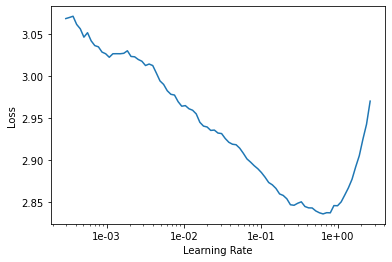

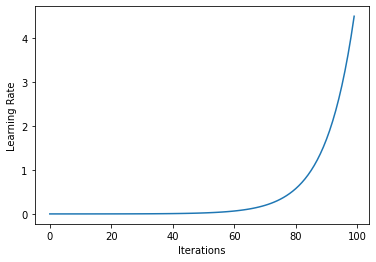

In [ ]:
#TEST 23.5 - resnet18 L30 ALL Classes 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
global sys_size
sys_size = 30

create_learner(folder, d_type, seed, sys_size, batch_size=100, model=models.resnet18, model_str='resnet18')

In [ ]:
learn_sys_size=30
train_max_epochs(30, lr=0.01, epoch_chunk=1, load=True, csv_name='TEST 23.5 - resnet18 L30 ALL classes 4000 systems 30 epochs')

Number of batches =  26
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-0
Best training so far:  0
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,3.112170,2.895334,0.052632,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.01-mom=0


Result of validate (train):  [2.8837085, tensor(0.0627)]


Result of validate (valid):  [2.8953342, tensor(0.0526)]


train_acc =  0.0626923069357872


valid_acc =  0.05263157933950424
losses:  [3.1121697425842285]
validation_losses:  [2.8953342]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-1-max_lr=0.01-mom=0
Best training so far:  1
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,3.022674,2.912294,0.057416,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.01-mom=0


Result of validate (train):  [2.906922, tensor(0.0569)]


Result of validate (valid):  [2.9122937, tensor(0.0574)]


train_acc =  0.05692307651042938


valid_acc =  0.057416267693042755
losses:  [3.1121697425842285, 3.022674083709717]
validation_losses:  [2.8953342, 2.9122937]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-2-max_lr=0.01-mom=0
Best training so far:  2
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.947031,2.930790,0.066986,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.01-mom=0


Result of validate (train):  [2.9395523, tensor(0.0646)]


Result of validate (valid):  [2.9307902, tensor(0.0670)]


train_acc =  0.0642307698726654


valid_acc =  0.06698564440011978
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164]
validation_losses:  [2.8953342, 2.9122937, 2.9307902]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-3-max_lr=0.01-mom=0
Best training so far:  3
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.863032,2.893003,0.062201,01:07


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.01-mom=0


Result of validate (train):  [2.8115044, tensor(0.0835)]


Result of validate (valid):  [2.8930027, tensor(0.0622)]


train_acc =  0.08423076570034027


valid_acc =  0.06220095604658127
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-4-max_lr=0.01-mom=0
Best training so far:  4
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.821613,2.858197,0.087719,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.01-mom=0


Result of validate (train):  [2.5571344, tensor(0.2108)]


Result of validate (valid):  [2.858197, tensor(0.0877)]


train_acc =  0.21115384995937347


valid_acc =  0.08771929889917374
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-5-max_lr=0.01-mom=0
Best training so far:  5
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.783180,2.857900,0.078150,01:12


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.01-mom=0


Result of validate (train):  [2.477763, tensor(0.2588)]


Result of validate (valid):  [2.8579004, tensor(0.0781)]


train_acc =  0.2588461637496948


valid_acc =  0.07814992219209671
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-6-max_lr=0.01-mom=0
Best training so far:  6
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.709705,2.854379,0.082935,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.01-mom=0


Result of validate (train):  [2.413796, tensor(0.3012)]


Result of validate (valid):  [2.8543794, tensor(0.0829)]


train_acc =  0.30115383863449097


valid_acc =  0.08293461054563522
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-7-max_lr=0.01-mom=0
Best training so far:  7
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.641144,2.855559,0.089314,01:09


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-8-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-8-max_lr=0.01-mom=0


Result of validate (train):  [2.350275, tensor(0.3315)]


Result of validate (valid):  [2.8555589, tensor(0.0893)]


train_acc =  0.33115383982658386


valid_acc =  0.08931419253349304
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-8-max_lr=0.01-mom=0
Best training so far:  8
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.601826,2.851034,0.098884,01:09


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-9-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-9-max_lr=0.01-mom=0


Result of validate (train):  [2.2854602, tensor(0.3758)]


Result of validate (valid):  [2.851034, tensor(0.0989)]


train_acc =  0.375


valid_acc =  0.09888356924057007
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-9-max_lr=0.01-mom=0
Best training so far:  9
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.535365,2.843800,0.098884,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-10-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-10-max_lr=0.01-mom=0


Result of validate (train):  [2.227561, tensor(0.4138)]


Result of validate (valid):  [2.8437998, tensor(0.0989)]


train_acc =  0.4142307639122009


valid_acc =  0.09888356924057007
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-10-max_lr=0.01-mom=0
Best training so far:  10
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.505457,2.840941,0.105263,01:12


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-11-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-11-max_lr=0.01-mom=0


Result of validate (train):  [2.1692398, tensor(0.4619)]


Result of validate (valid):  [2.8409407, tensor(0.1053)]


train_acc =  0.4619230628013611


valid_acc =  0.10526315867900848
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-11-max_lr=0.01-mom=0
Best training so far:  11
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.427191,2.844559,0.094099,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-12-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-12-max_lr=0.01-mom=0


Result of validate (train):  [2.1082945, tensor(0.5050)]


Result of validate (valid):  [2.844559, tensor(0.0941)]


train_acc =  0.504230797290802


valid_acc =  0.09409888088703156
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-12-max_lr=0.01-mom=0
Best training so far:  12
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.379802,2.841668,0.094099,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-13-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-13-max_lr=0.01-mom=0


Result of validate (train):  [2.0508258, tensor(0.5492)]


Result of validate (valid):  [2.8416681, tensor(0.0941)]


train_acc =  0.5492307543754578


valid_acc =  0.09409888088703156
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-13-max_lr=0.01-mom=0
Best training so far:  13
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.360164,2.837961,0.097289,01:09


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-14-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-14-max_lr=0.01-mom=0


Result of validate (train):  [1.9937888, tensor(0.5927)]


Result of validate (valid):  [2.8379614, tensor(0.0973)]


train_acc =  0.5923076868057251


valid_acc =  0.09728867560625076
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-14-max_lr=0.01-mom=0
Best training so far:  14
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.279133,2.837941,0.106858,01:07


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-15-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-15-max_lr=0.01-mom=0


Result of validate (train):  [1.936166, tensor(0.6231)]


Result of validate (valid):  [2.8379412, tensor(0.1069)]


train_acc =  0.6226922869682312


valid_acc =  0.10685805231332779
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-15-max_lr=0.01-mom=0
Best training so far:  15
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.227555,2.836166,0.098884,01:11


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-16-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-16-max_lr=0.01-mom=0


Result of validate (train):  [1.8796817, tensor(0.6588)]


Result of validate (valid):  [2.8361661, tensor(0.0989)]


train_acc =  0.6596153974533081


valid_acc =  0.09888356924057007
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-16-max_lr=0.01-mom=0
Best training so far:  16
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.171146,2.837546,0.108453,01:07


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-17-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-17-max_lr=0.01-mom=0


Result of validate (train):  [1.8176733, tensor(0.6904)]


Result of validate (valid):  [2.8375456, tensor(0.1085)]


train_acc =  0.6899999976158142


valid_acc =  0.10845295339822769
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379, 2.1711463928222656]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661, 2.8375456]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-17-max_lr=0.01-mom=0
Best training so far:  17
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.137430,2.836991,0.102073,01:07


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-18-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-18-max_lr=0.01-mom=0


Result of validate (train):  [1.762826, tensor(0.7227)]


Result of validate (valid):  [2.836991, tensor(0.1021)]


train_acc =  0.7215384840965271


valid_acc =  0.10207336395978928
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379, 2.1711463928222656, 2.137430429458618]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661, 2.8375456, 2.836991]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-18-max_lr=0.01-mom=0
Best training so far:  18
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.055903,2.835366,0.111643,01:07


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-19-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-19-max_lr=0.01-mom=0


Result of validate (train):  [1.7014425, tensor(0.7581)]


Result of validate (valid):  [2.835366, tensor(0.1116)]


train_acc =  0.7584615349769592


valid_acc =  0.1116427406668663
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379, 2.1711463928222656, 2.137430429458618, 2.0559029579162598]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661, 2.8375456, 2.836991, 2.835366]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-19-max_lr=0.01-mom=0
Best training so far:  19
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,2.014029,2.833055,0.106858,01:08


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-20-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-20-max_lr=0.01-mom=0


Result of validate (train):  [1.6458567, tensor(0.7854)]


Result of validate (valid):  [2.8330545, tensor(0.1069)]


train_acc =  0.7850000262260437


valid_acc =  0.10685805231332779
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379, 2.1711463928222656, 2.137430429458618, 2.0559029579162598, 2.014028549194336]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661, 2.8375456, 2.836991, 2.835366, 2.8330545]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-20-max_lr=0.01-mom=0
Best training so far:  20
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, None)


epoch,train_loss,valid_loss,accuracy,time
0,1.969654,2.833452,0.105263,01:09


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-21-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-21-max_lr=0.01-mom=0


Result of validate (train):  [1.5906926, tensor(0.8115)]


Result of validate (valid):  [2.8334517, tensor(0.1053)]


train_acc =  0.810769259929657


valid_acc =  0.10526315867900848
losses:  [3.1121697425842285, 3.022674083709717, 2.947031021118164, 2.863032102584839, 2.821612596511841, 2.783179998397827, 2.709705352783203, 2.641144275665283, 2.6018259525299072, 2.535364866256714, 2.5054569244384766, 2.4271905422210693, 2.3798015117645264, 2.3601644039154053, 2.279132843017578, 2.227555274963379, 2.1711463928222656, 2.137430429458618, 2.0559029579162598, 2.014028549194336, 1.9696542024612427]
validation_losses:  [2.8953342, 2.9122937, 2.9307902, 2.8930027, 2.858197, 2.8579004, 2.8543794, 2.8555589, 2.851034, 2.8437998, 2.8409407, 2.844559, 2.8416681, 2.8379614, 2.8379412, 2.8361661, 2.8375456, 2.836991, 2.835366, 2.8330545, 2.8334517]
loading epoch  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-21-max_lr=0.01-mom=0
Best training so far:  21
Using (max) lr of:  0.01
lr being used:  slice(1e-06, 0.0001, No

epoch,train_loss,valid_loss,accuracy,time
0,1.913235,2.835994,0.110048,01:10


/content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-22-max_lr=0.01-mom=0
Saving epoch chunk as:  /content/drive/MyDrive/ModelStages/30/classes=17CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=100-ntrain=raw_data_transfering_200_30_training_1111/epochs-22-max_lr=0.01-mom=0


KeyboardInterrupt: ignored

###L50 final tests

####TEST 24 - Resnet18 L50 system size 4000 extreme

In [ ]:
#TEST 24 - resnet18 L50 extreme 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=True, batch_size=150, model=models.resnet18, model_str='resnet18')

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 24 - resnet18 L50 extreme 4000 systems 30 epochs')

####TEST 25 - Resnet18 L50 system size 4000 extreme and one in the middle

In [ ]:
#TEST 25 - resnet18 L50 extreme and one in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=225, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,9])

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 25 - resnet18 L50 extreme and one in the middle 4000 systems 30 epochs')

####TEST 26 - Resnet18 L20 system size 4000 extreme and two in the middle

In [ ]:
#TEST 26 - resnet18 L50 extreme and two in middle 4000 systems 30 epochs
folder   = 'raw_data_transfering_4000_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, batch_size=300, model=models.resnet18, model_str='resnet18', inc_spec_features=[-1,0,6,11])

In [ ]:
train_max_epochs(30, lr='BEST', epoch_chunk=1, load=False, csv_name='TEST 26 - resnet18 L50 extreme and two in the middle 4000 systems 30 epochs')

# Interpretation and plot making


In [29]:
def show_confs(dir):
  #dir = '/content/drive/MyDrive/ModelStages/'+c_model
  epochs = !ls -l {dir}
  epochs.reverse()
  epochs.pop()

  max_epoch_value = 0
  for i in range(len(epochs)):
    epochs[i] = epochs[i].rsplit(' ',1)[1]
    epochs[i] = epochs[i].rsplit('.',1)[0]
    #print(epochs[i])
    try:
      epochs[i] = epochs[i].rsplit('\'',1)[1]
    except:
      print("The string you tried to split isnt valid")
    #print(epochs[i])
  print(epochs)

  for epoch in epochs:
    learn.load(dir+'/'+epoch);
    preds,y,losses = learn.get_preds(with_loss=True)
    interp = ClassificationInterpretation(learn,preds,y,losses)
    interp.plot_confusion_matrix(figsize=(7,7))
    print(epoch)

folder for prep_data:  raw_data_transfering_200_50_
Found pre-loaded data raw_data_50/raw_data_transfering_200_50_training_seed1111


---------
   Length of training set:  17
   Length of validation set:  17
   Length of testing set:  17
---------


Saving the model as:  /content/drive/MyDrive/ModelStages/50/17/classes=17-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=10-ntrain=raw_data_transfering_200_50_training_1111
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/50’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/50/17’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/ModelStages/50/17/classes=17-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=10-ntrain=raw_data_transfering_200_50_training_1111’: File exists
Model len:  2
Layer:      Sequential(
  (0): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best lr for this learner is:  0.010484726396954804
The string you tried to split isnt valid
['epochs-9-max_lr=0.01-mom=0', 'epochs-8-max_lr=0.01-mom=0', 'epochs-7-max_lr=0.01-mom=0', 'epochs-6-max_lr=0.01-mom=0', 'epochs-5-max_lr=0.01-mom=0', 'epochs-4-max_lr=0.01-mom=0', 'epochs-3-max_lr=0.01-mom=0', 'epochs-2-max_lr=0.01-mom=0', 'epochs-1-max_lr=0.01-mom=0', 'epochs-15-max_lr=0.01-mom=0', 'epochs-14-max_lr=0.01-mom=0', 'epochs-13-max_lr=0.01-mom=0', 'epochs-12-max_lr=0.01-mom=0', 'epochs-11-max_lr=0.01-mom=0', 'epochs-10-max_lr=0.01-mom=0', 'epochs-0']


epochs-9-max_lr=0.01-mom=0


epochs-8-max_lr=0.01-mom=0


epochs-7-max_lr=0.01-mom=0


epochs-6-max_lr=0.01-mom=0


epochs-5-max_lr=0.01-mom=0


epochs-4-max_lr=0.01-mom=0


epochs-3-max_lr=0.01-mom=0


epochs-2-max_lr=0.01-mom=0


epochs-1-max_lr=0.01-mom=0


epochs-15-max_lr=0.01-mom=0


epochs-14-max_lr=0.01-mom=0


epochs-13-max_lr=0.01-mom=0


epochs-12-max_lr=0.01-mom=0


epochs-11-max_lr=0.01-mom=0


epochs-10-max_lr=0.01-mom=0


epochs-0


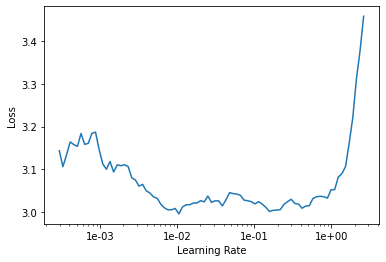

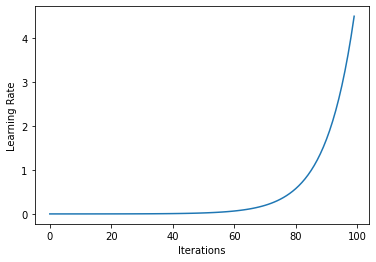

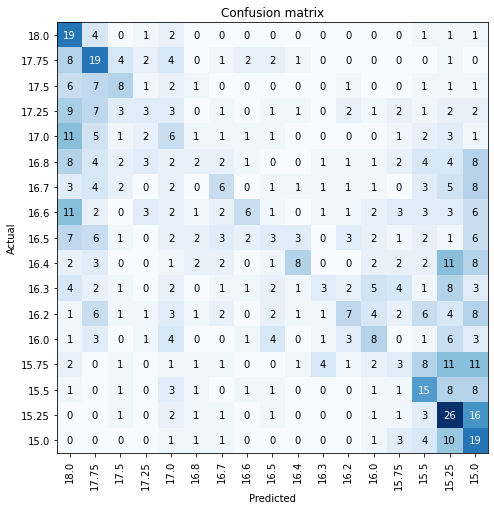

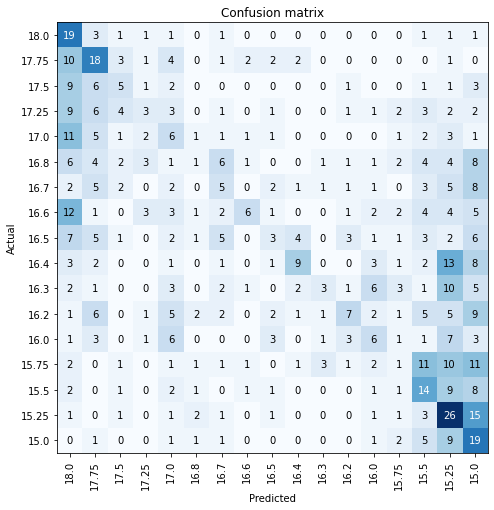

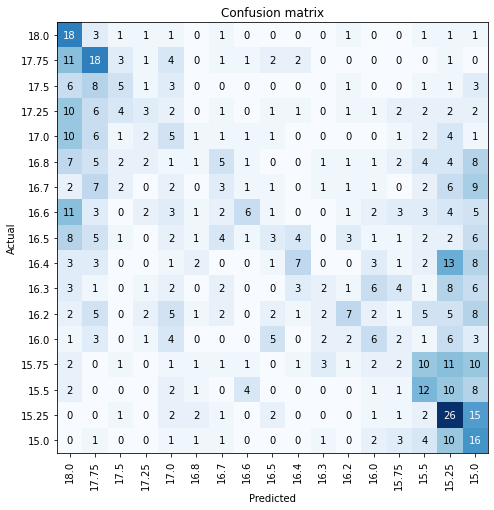

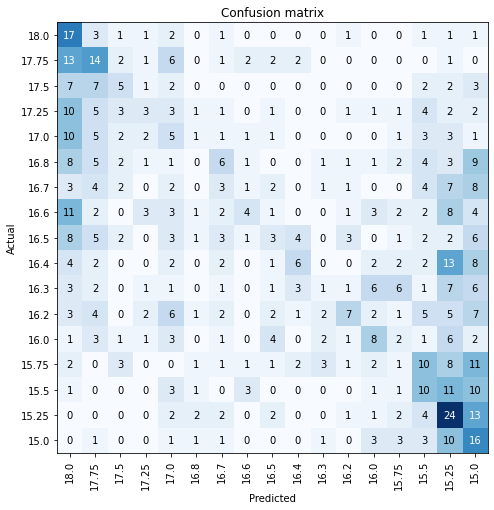

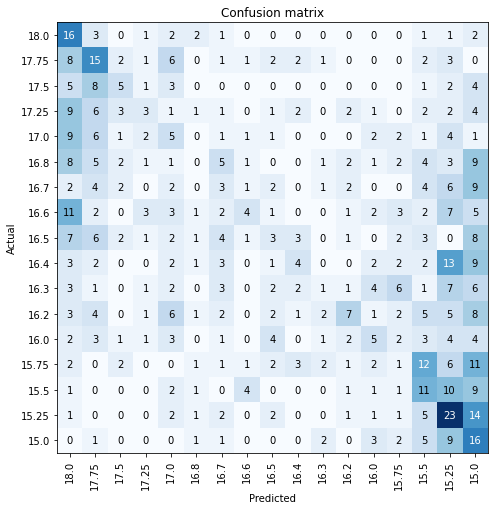

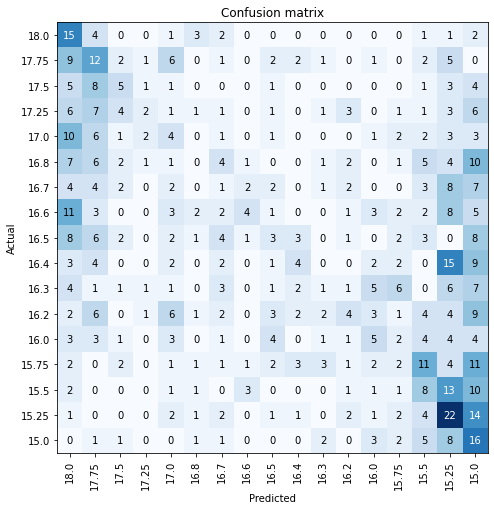

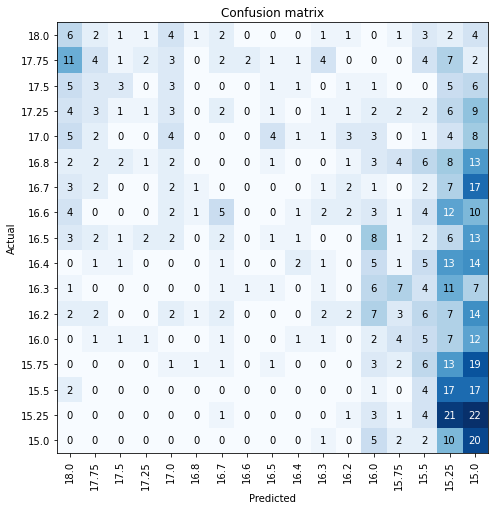

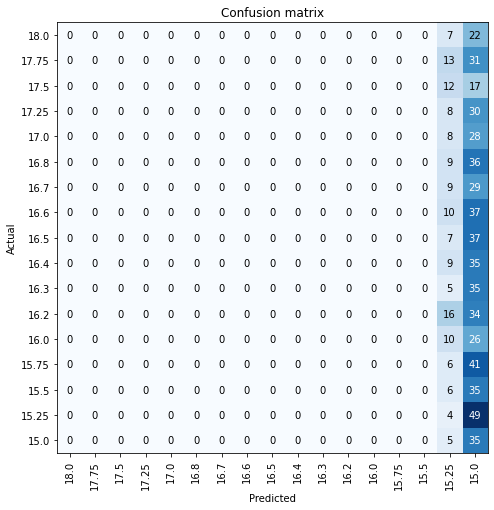

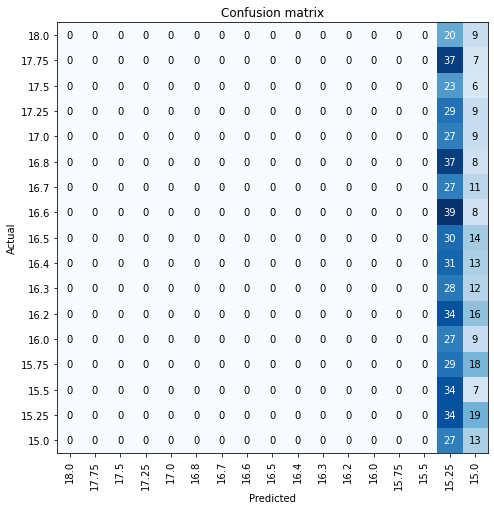

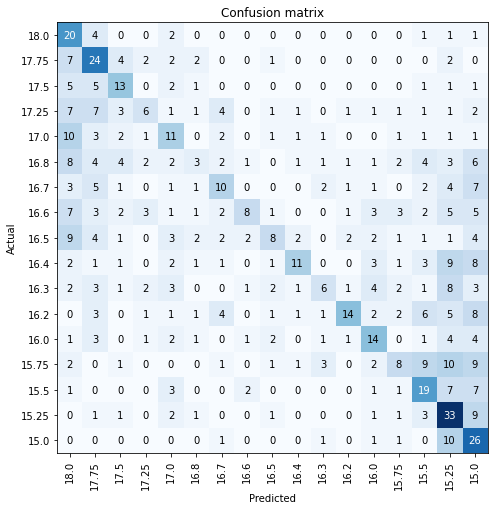

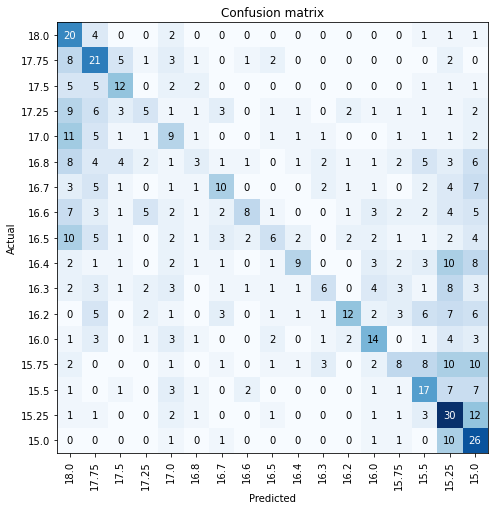

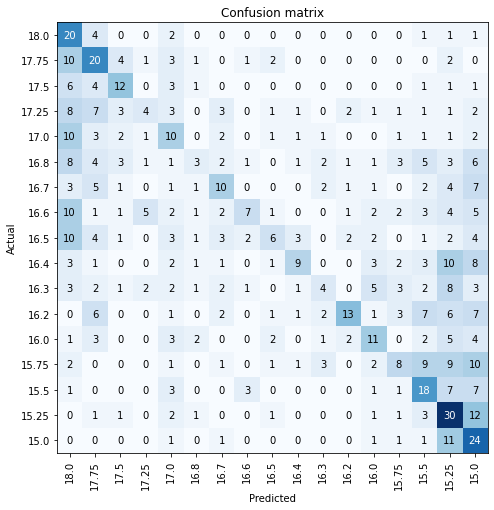

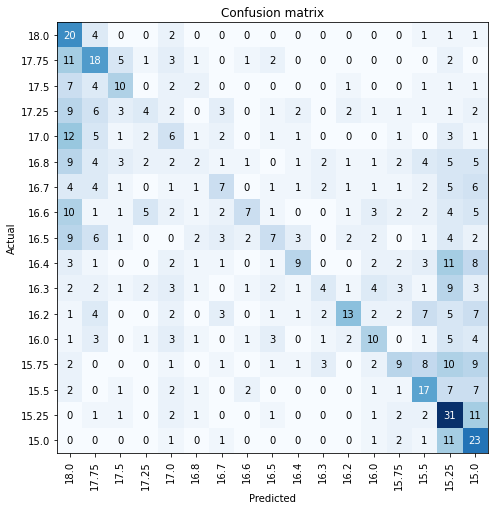

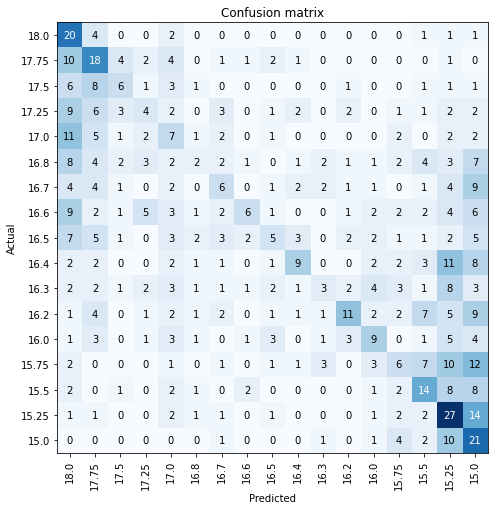

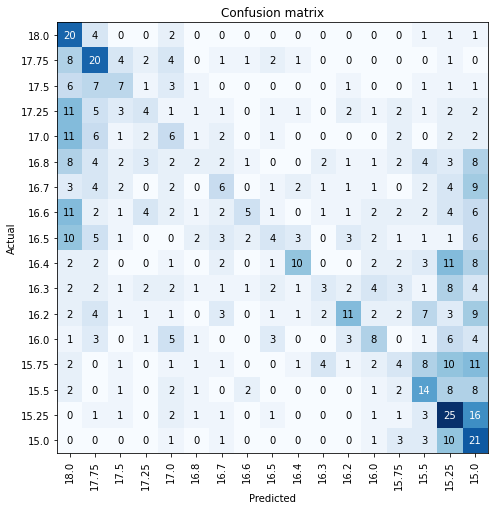

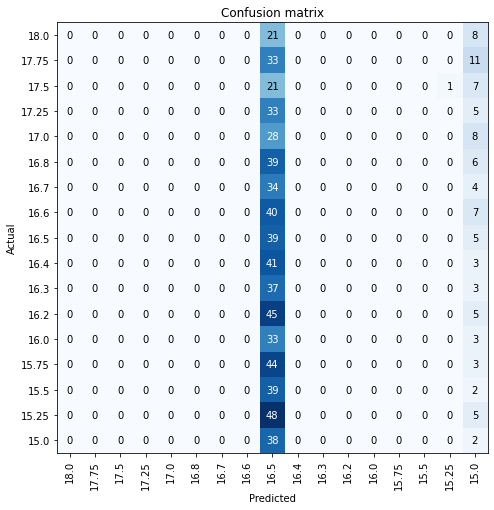

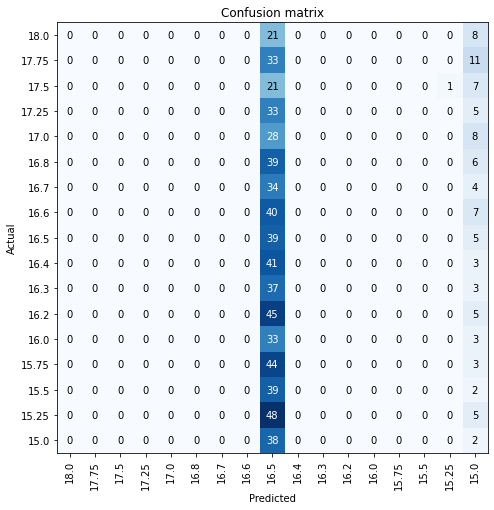

In [30]:
folder   = 'raw_data_transfering_200_'
d_type   = d_type_opt[0]
seed     = str(1111)
sys_size = 50

create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=10, model=models.resnet18, model_str='resnet18')  #BS is 1/40th of the total samples

show_confs('/content/drive/MyDrive/ModelStages/50/17/classes=17-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=320-ntrain=raw_data_transfering_1000_50_training_1111')

#learn.load('/content/drive/MyDrive/ModelStages/'+c_model+'/epochs-10');
#learn.load('/content/drive/MyDrive/ModelStages/'+'CONV2D-resnet18_error_rate_loss=default'+'/epochs-210');
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn,preds,y,losses)
interp.plot_confusion_matrix(figsize=(7,7))

Getting the accuracies from existing models

In [ ]:
def get_accuracies(dir):
  train_accuracy_list = []
  valid_accuracy_list = []

  #TEST 24 - resnet18 L50 extreme 200 systems 30 epochs
  folder   = 'raw_data_transfering_1000_'
  d_type   = d_type_opt[0]
  seed     = str(1111)
  sys_size = 50

  create_learner(folder, d_type, seed, sys_size, show_model=False, extr=False, batch_size=150, model=models.resnet18, model_str='resnet18')

  model_epochs = !ls -l {dir}
  model_epochs.reverse()
  model_epochs.pop()

  for i in range(len(model_epochs)):
      model_epochs[i] = model_epochs[i].rsplit(' ',1)[1]
      model_epochs[i] = model_epochs[i].rsplit('.',1)[0]
      try:
        model_epochs[i] = model_epochs[i].rsplit('\'',1)[1]
      except:
        print("tried to remove \' but couldnt find one")

  for epoch in model_epochs:
    print(epoch)
    print("Result of validate (train): ", learn.validate(learn.data.train_dl))
    print("Result of validate (valid): ", learn.validate(learn.data.valid_dl))
    train_acc = float(learn.validate(learn.data.train_dl)[1])
    print("train_acc = ", train_acc)
    valid_acc = float(learn.validate(learn.data.valid_dl)[1])
    print("valid_acc = ", valid_acc)

    train_accuracy_list.append(train_acc)
    valid_accuracy_list.append(valid_acc)

  print("Results:")
  print(train_accuracy_list)
  print(valid_accuracy_list)
  return accuracy_list
get_accuracies('/content/drive/MyDrive/ModelStages/50/17/classes=17-CONV2D-resnet18-metric=error_rate-loss=CrossEntropyLoss-opt=ADAM-bs=318-ntrain=raw_data_transfering_1000_50_training_1111')

folder for prep_data:  raw_data_transfering_1000_50_
   Data directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/
Number of classes:  17
W18.0-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W18.0-1000data_seed1111.csv
W17.75-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W17.75-1000data_seed1111.csv
W17.5-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W17.5-1000data_seed1111.csv
W17.25-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_training_seed1111/W17.25-1000data_seed1111.csv
W17.0-1000data_seed1111.csv
Actual file directory:  /content/drive/MyDrive/csvdata/raw_data_50/raw_data_transfering_1000_50_train

##Plot making


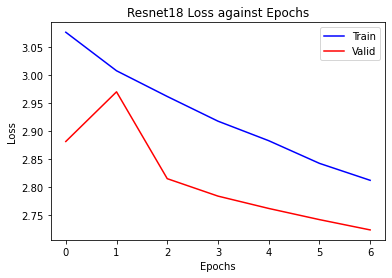

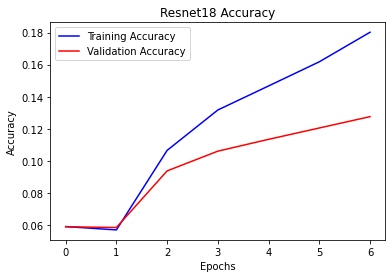

In [ ]:
train_loss_data = []
valid_loss_data = []
accuracy_data   = []
df = pd.read_csv('/content/drive/MyDrive/test_results/Backup TEST 23.5 - resnet18 L30 ALL classes 4000 systems 30 epochs.csv')
train_loss_data = df['Training Loss']
valid_loss_data = df['Validation Loss']
train_accuracy_data   = df['Training Accuracy']
valid_accuracy_data   = df['Validation Accuracy']

plt.plot(range(len(train_loss_data)), train_loss_data, '-b',label='Train')
plt.plot(range(len(valid_loss_data)), valid_loss_data, '-r', label='Valid')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Resnet18 Loss against Epochs')
plt.show()
plt.plot(range(len(train_accuracy_data)), train_accuracy_data, '-b', label='Training Accuracy')
plt.plot(range(len(valid_accuracy_data)), valid_accuracy_data, '-r', label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Resnet18 Accuracy')
plt.show()

##General Testing Area

In [ ]:
folder = 'raw_data_transfering_200_'
d_type = d_type_opt[0]

create_learner(folder, d_type, save=False)

preds,targs = learn.get_preds()
print(targs)
print(preds)
print(len(preds))

learn.pred_batch()

#Hyperparameter Optimisation Test area

##Our own grid search algorithm

In [ ]:
parameter_lims = {}
parameter_lims['bs']  = [20,30,40]
parameter_lims['opt'] = [optim.Adam,optim.AdamW]
parameter_lims['mom'] = [0,0.5,0.9]
lr = 0.1

for bs_val in parameter_lims['bs']:
  for opt_val in parameter_lims['opt']:
    for mom_val in parameter_lims['mom']:
      train_losses,valid_losses = train_with_parameters(1,bs_val, opt_val, mom_val, 0, lr)
      print("parameters: bs_val=", bs_val, " opt=", opt_val, " mom=", mom_val)
      print("train_loss=", train_losses[-1])
      print("valid_loss=", valid_losses[-1])

##Online grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from torch import nn
import numpy as np
from sklearn.datasets import make_classification
!pip install --user skorch
from skorch import NeuralNetClassifier

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=nn.ReLU()):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)


net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)
gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

     |████████████████████████████████| 133kB 6.7MB/s 
ERROR: Operation cancelled by user


ModuleNotFoundError: ignored